In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftshift, fftfreq
from scipy import signal
import nmrglue as ng

# Basic frequency shifting
### Here we have taken a signal with a a frequency of 1 and shifted it to a frequency of 2. The Fourier transform is shifted from a symmetric to asymmetric system.

C:\Users\nebarlow\anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


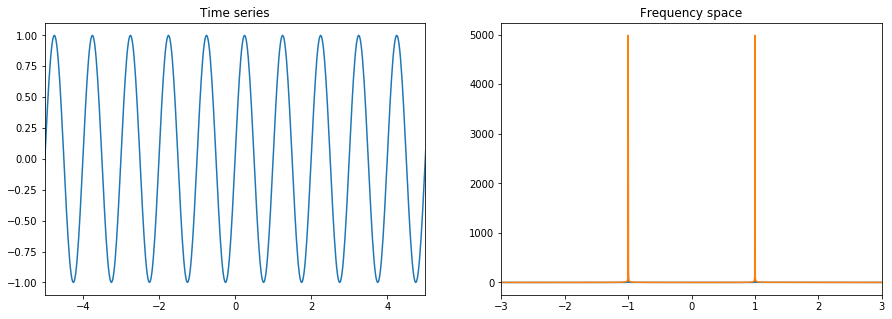

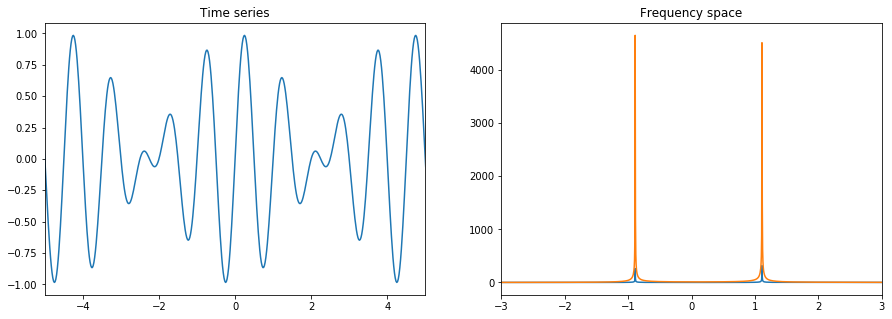

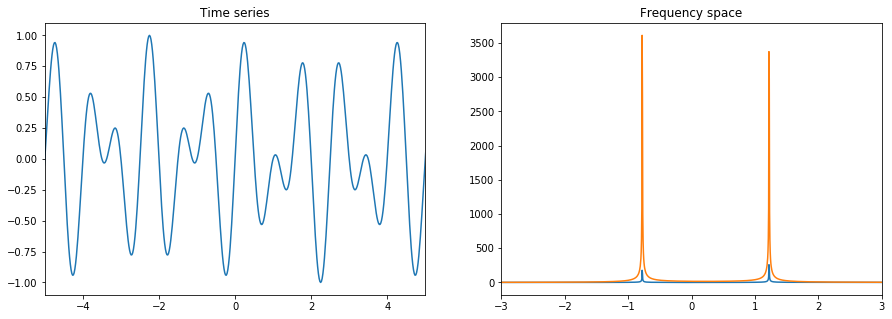

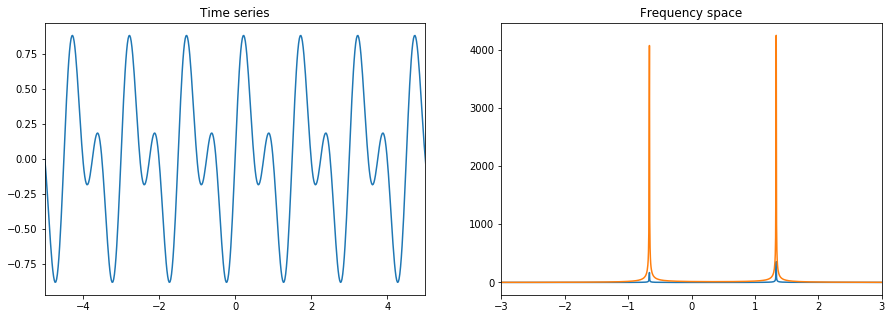

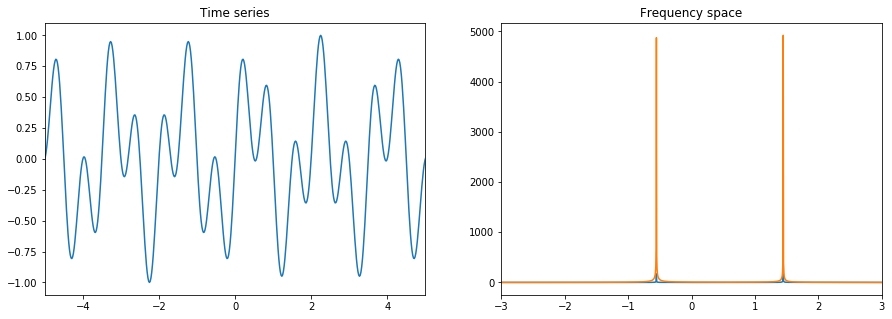

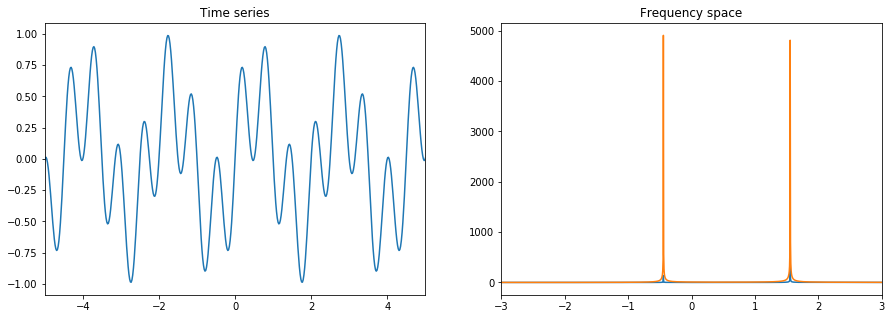

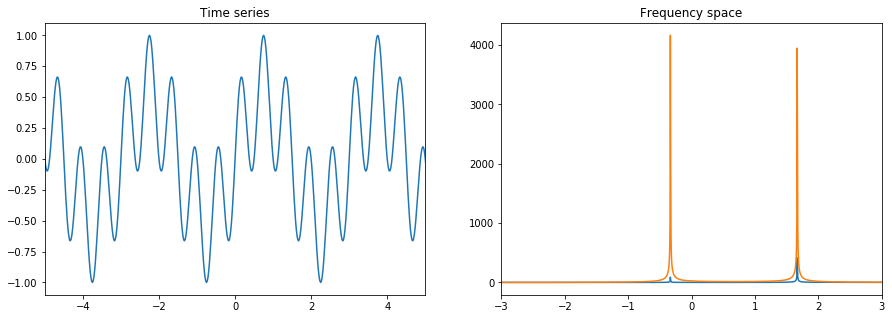

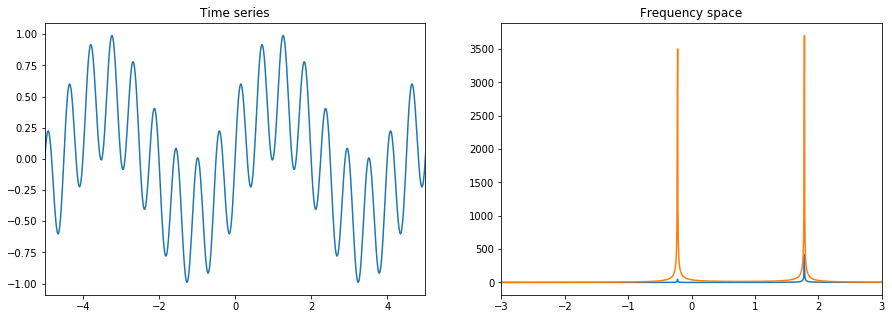

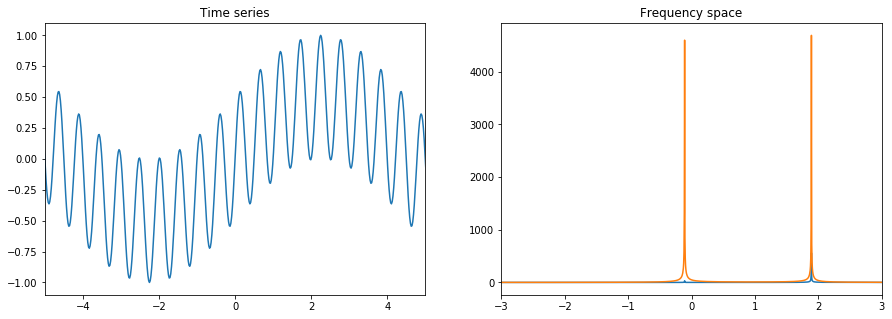

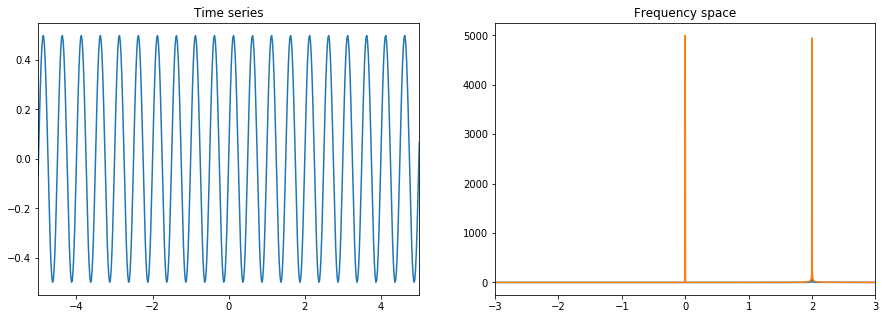

In [2]:
# simple sine wave
x = np.linspace(-100,100,10000)
y = np.sin(np.pi*2*x*1)

# iterate through phase shift tau
for tau in np.linspace(0,1,10):
    y_s = y*np.exp(-1j*np.pi*2*tau*x)

    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title('Time series')
    plt.plot(x,y_s)
    plt.xlim(-5,5)

    ft = fftshift(fft(y_s))
    freq = fftshift(fftfreq(10000, x[0]-x[1]))

    plt.subplot(1,2,2)
    plt.title('Frequency space')
    plt.plot(freq,abs(ft.real))
    plt.plot(freq,abs(ft.imag))
    plt.xlim(-3,3)

    plt.show()
    


# Basic Phase Correction of Time Series

### Phase correction uses a shift with the constant phase angle PH0 and total variation across the spectrum PH1, as described [here](https://www.sciencedirect.com/science/article/pii/S1090780709002730).

###  One can see how we have 3 frequencies in the signal which may be hidden without phase correction.


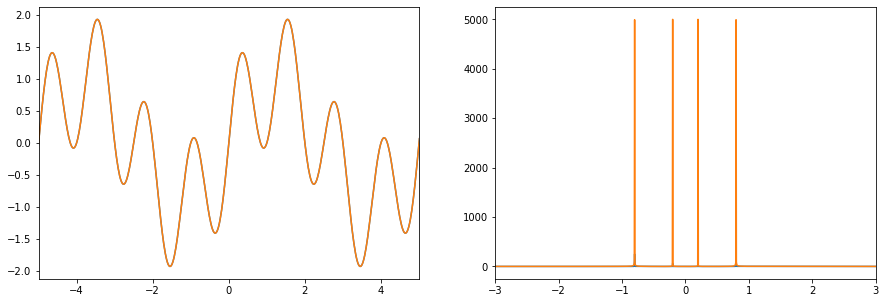

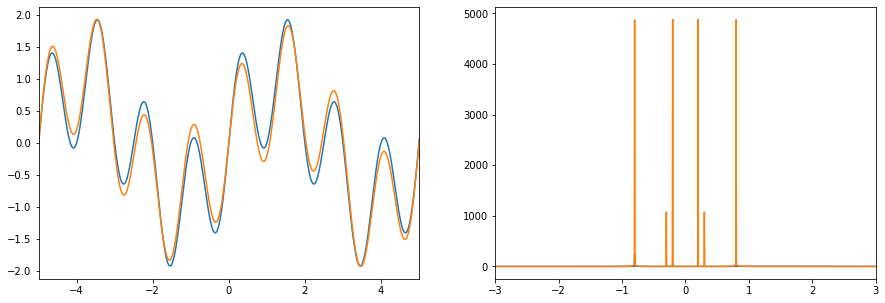

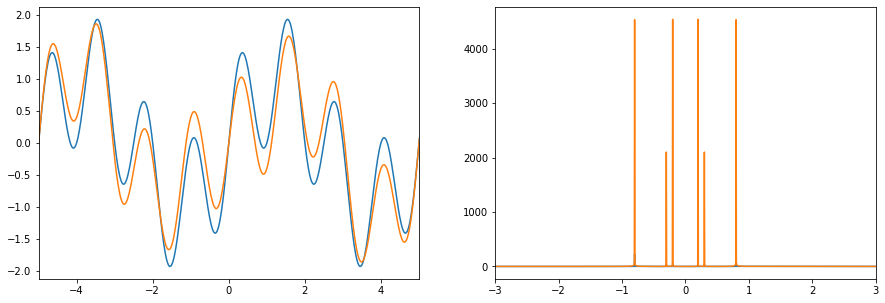

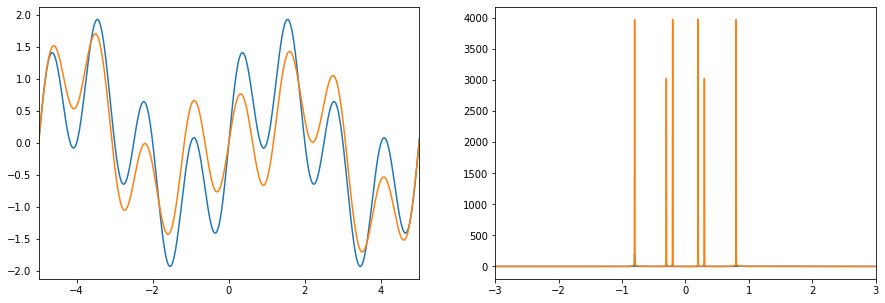

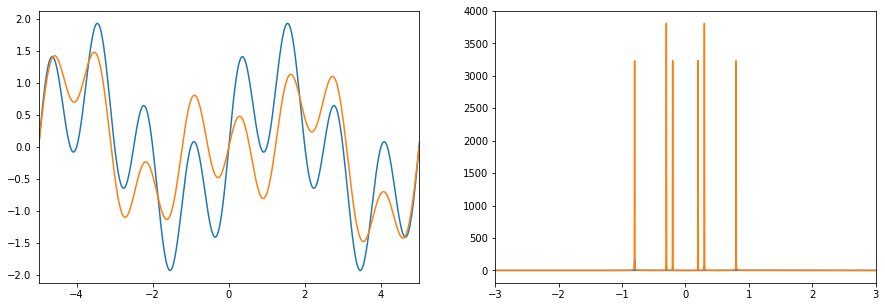

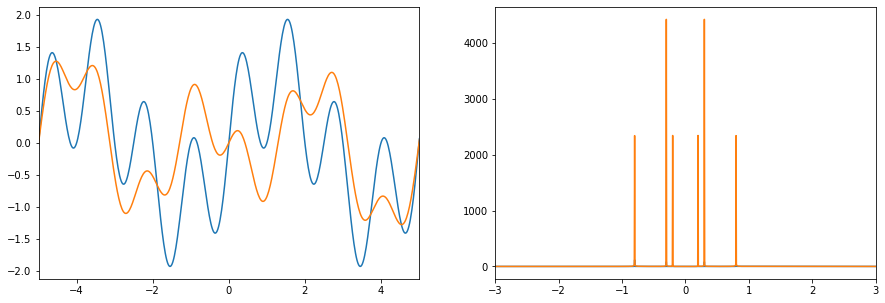

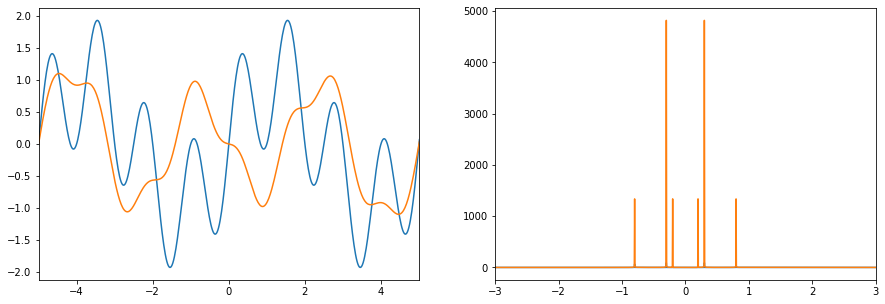

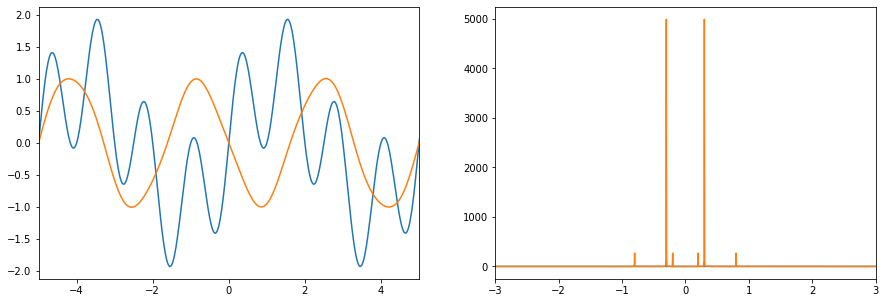

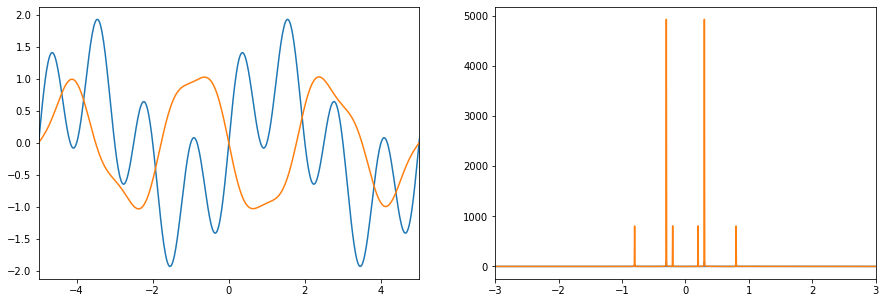

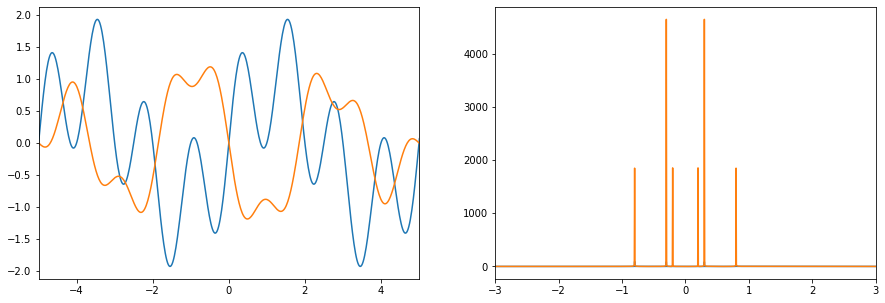

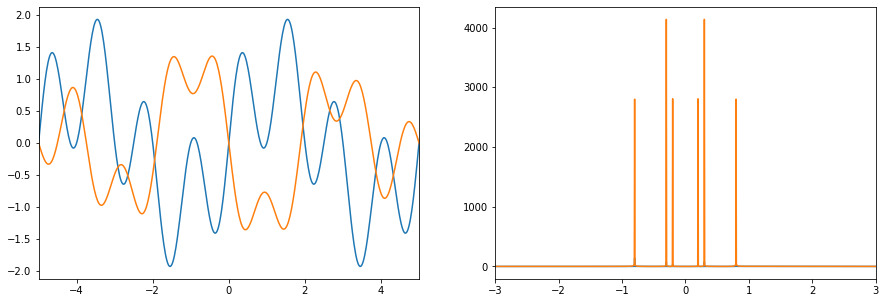

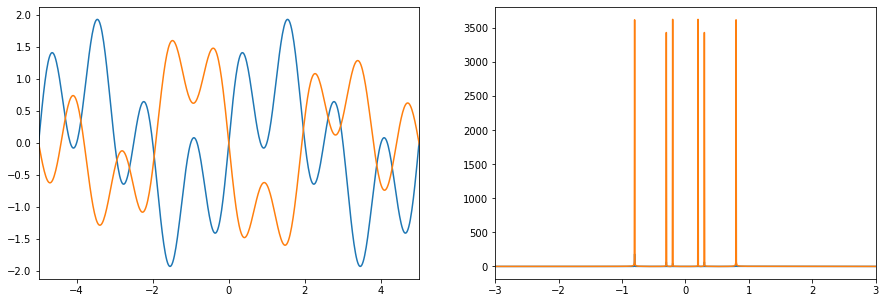

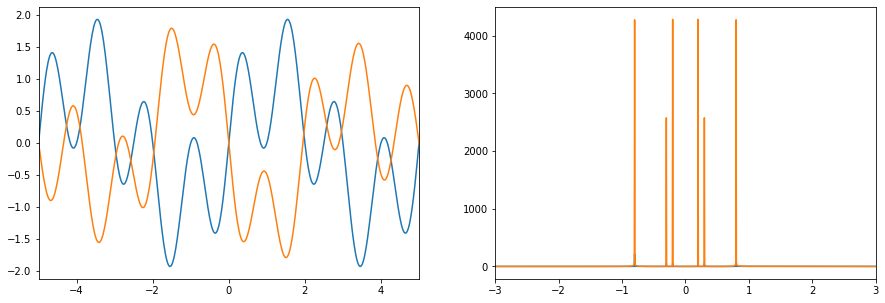

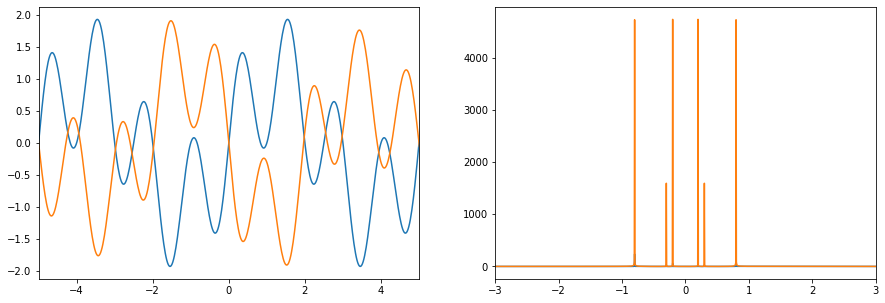

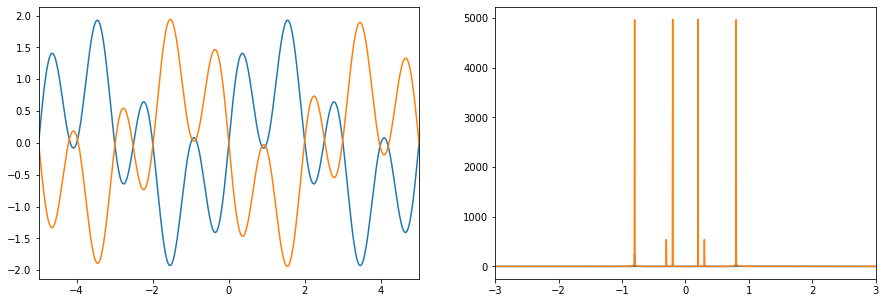

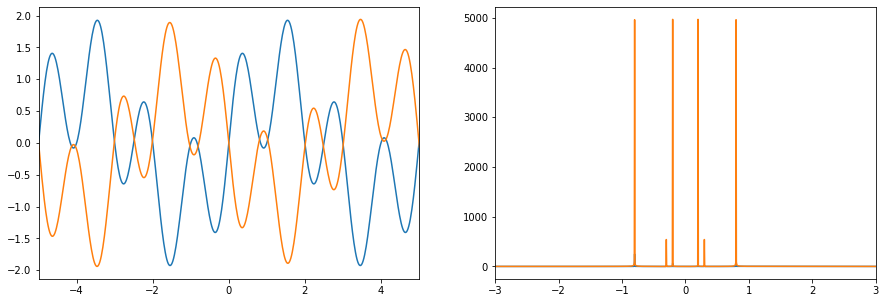

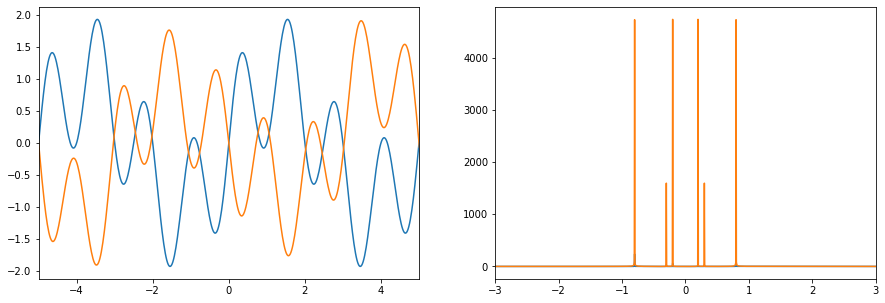

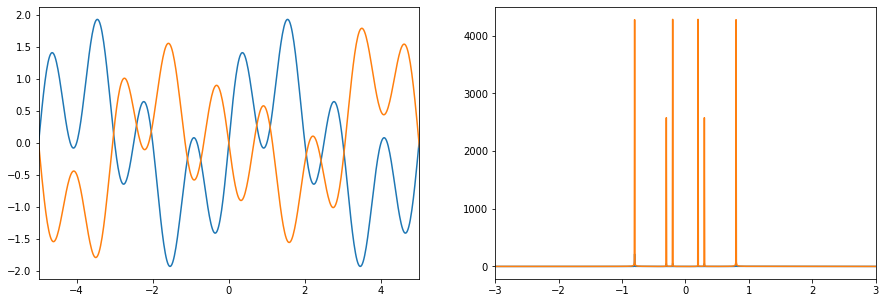

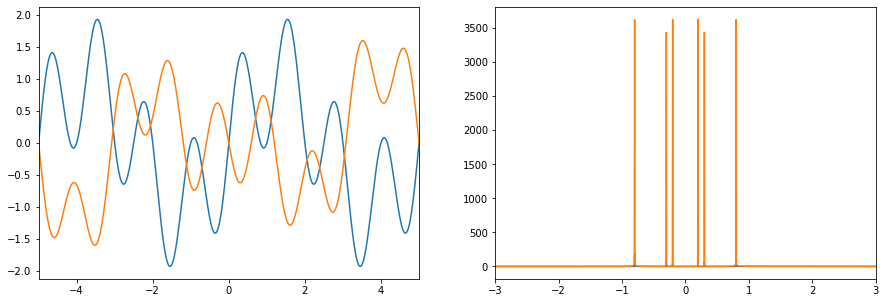

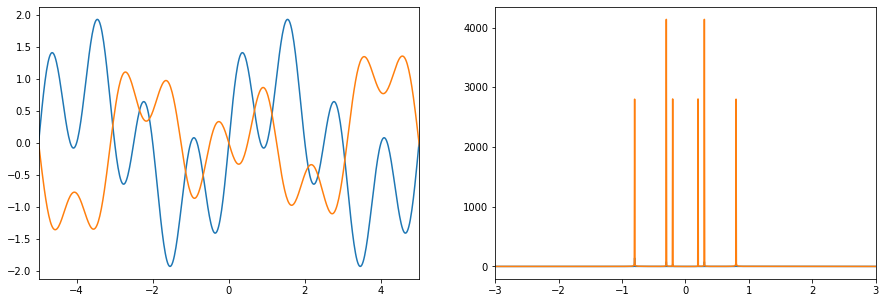

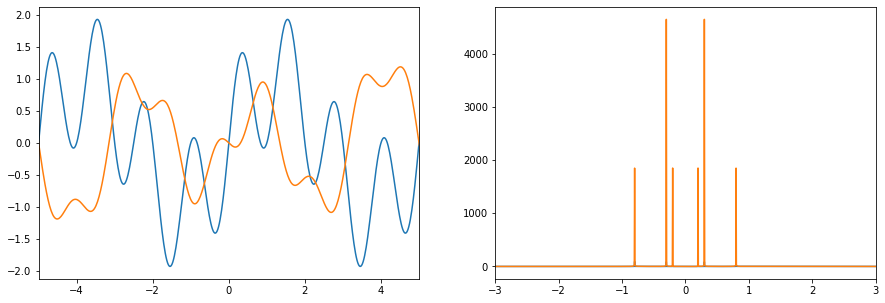

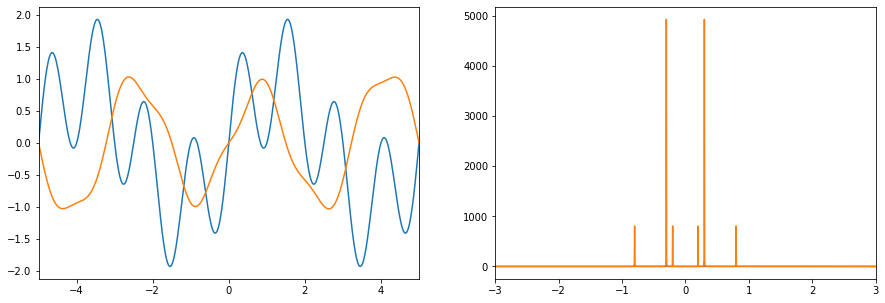

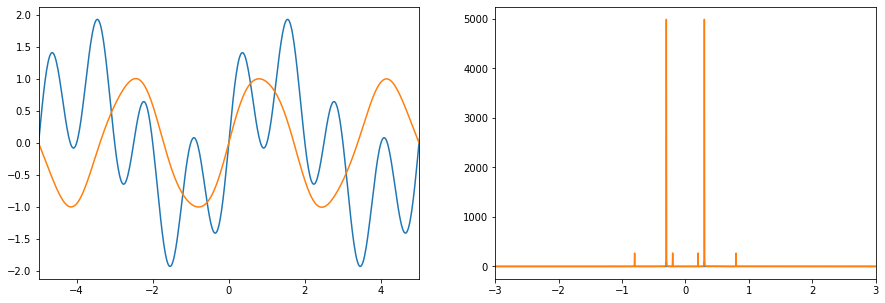

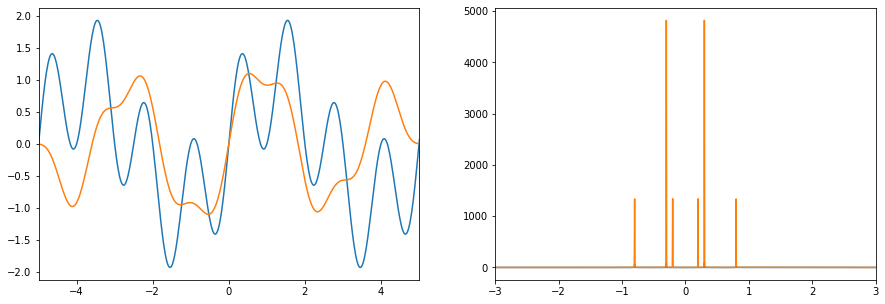

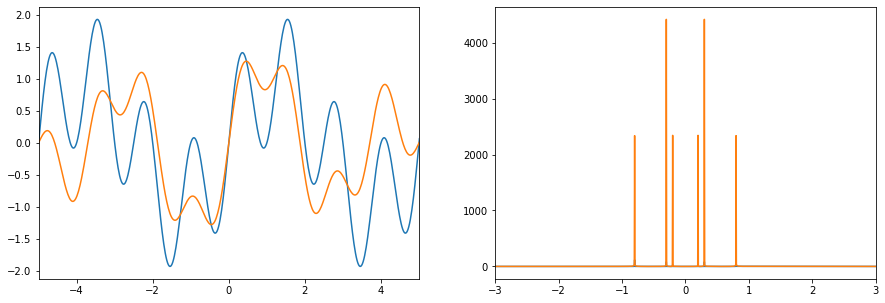

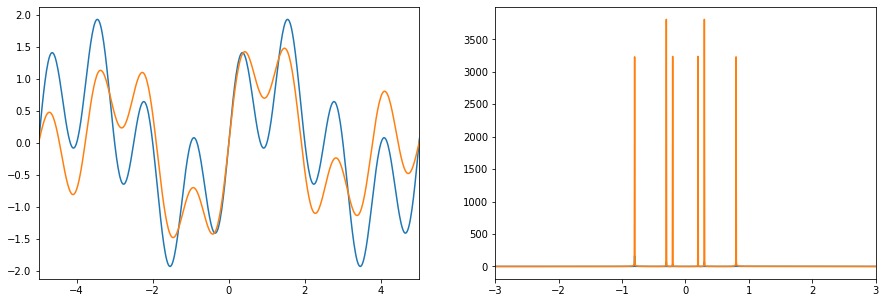

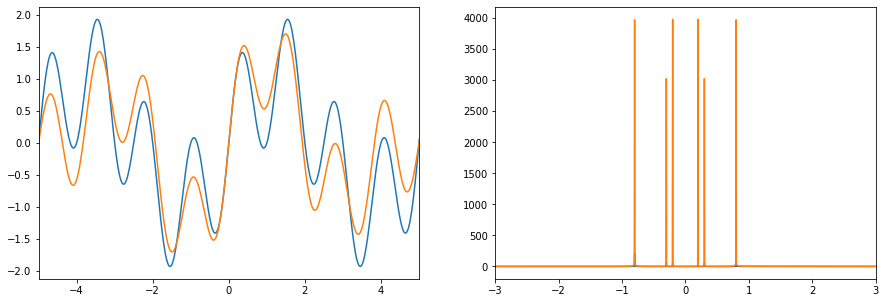

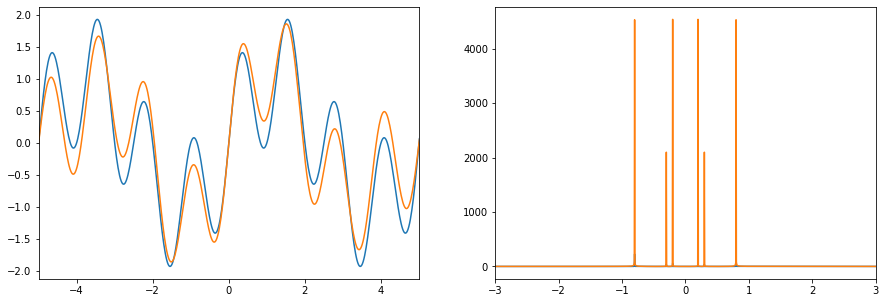

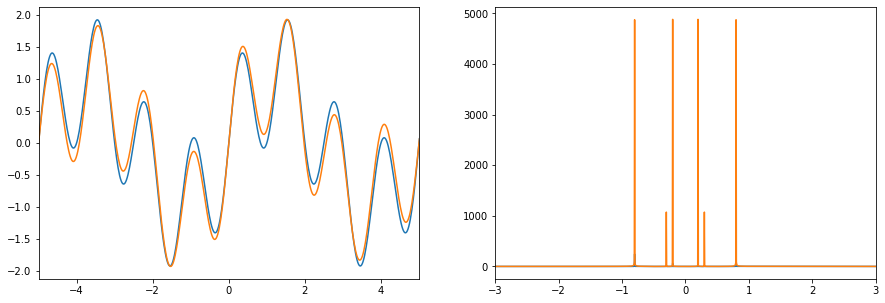

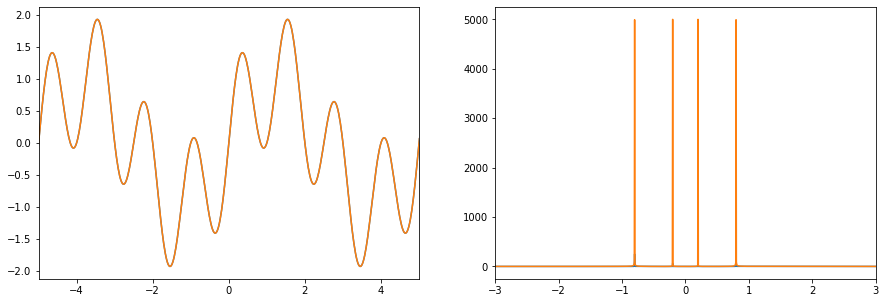

In [3]:
# simple sine wave
x = np.linspace(-100,100,10000)
y = np.sin(np.pi*2*x*0.8)+np.sin(np.pi*2*x*0.2)+1j*np.sin(np.pi*2*x*0.3)


PH1 = 0.0
# iterate through phase shift PH0
for PH0 in np.linspace(0,1,30):
    phi = PH0+np.arange(0,len(y),1)/len(y)*PH1
    y_s = y.real*np.cos(np.pi*2*phi)-y.imag*np.sin(np.pi*2*phi)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(x,y)
    plt.plot(x,y_s)
    plt.xlim(-5,5)

    ft = fftshift(fft(y_s))
    freq = fftshift(fftfreq(10000, x[0]-x[1]))

    plt.subplot(1,2,2)
    plt.plot(freq,abs(ft.real))
    plt.plot(freq,abs(ft.imag))
    plt.xlim(-3,3)

    plt.show()

# Basic Phase Correction of Fourier Space
### This works the same way after the signal has been transformed into the Fourier domain.

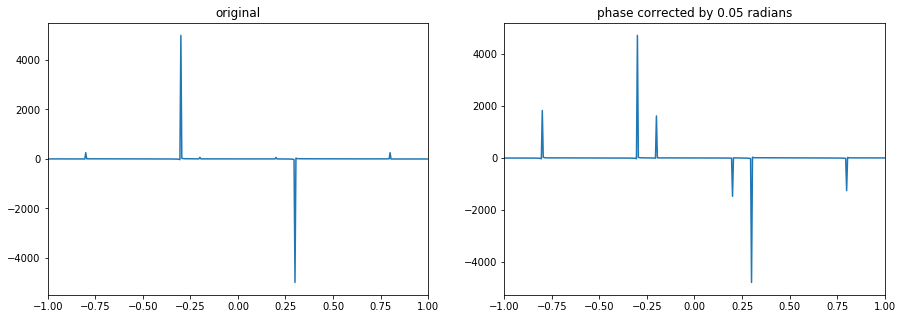

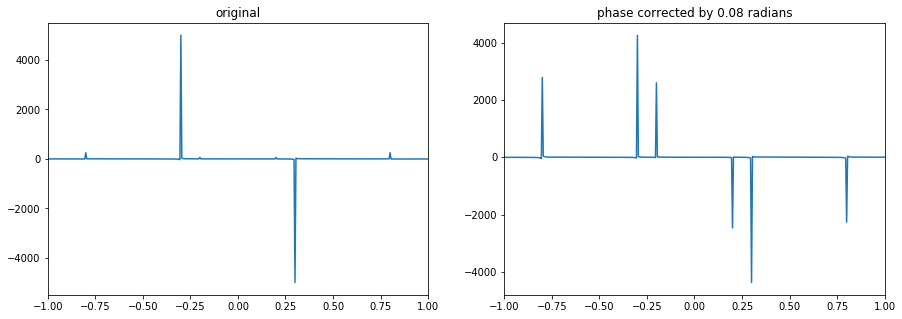

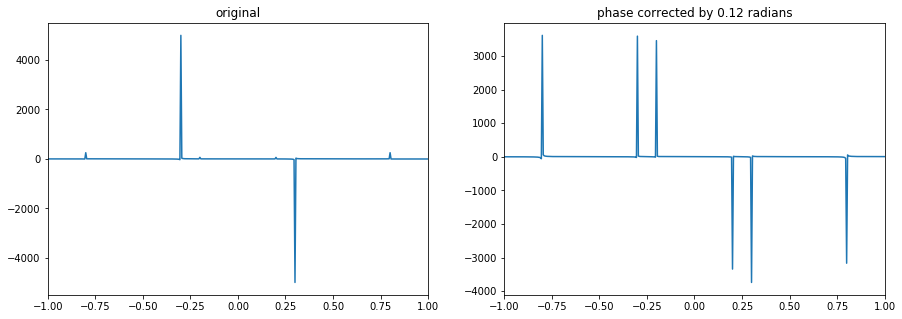

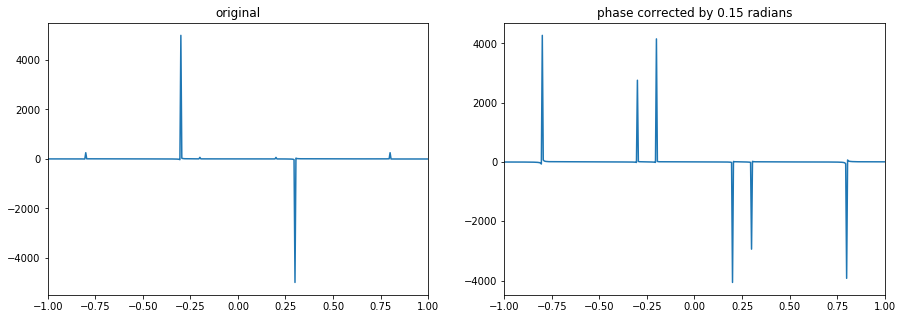

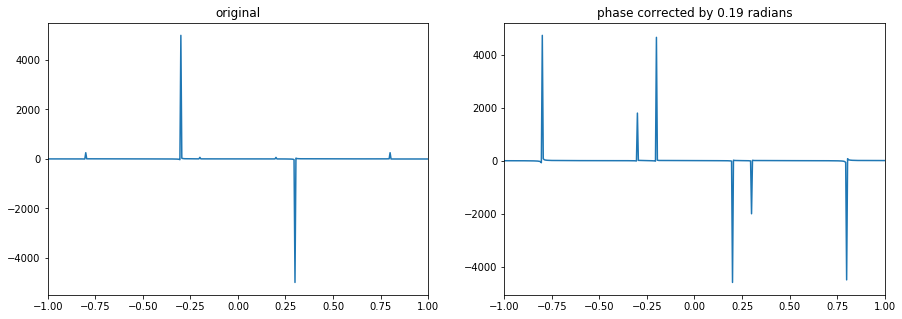

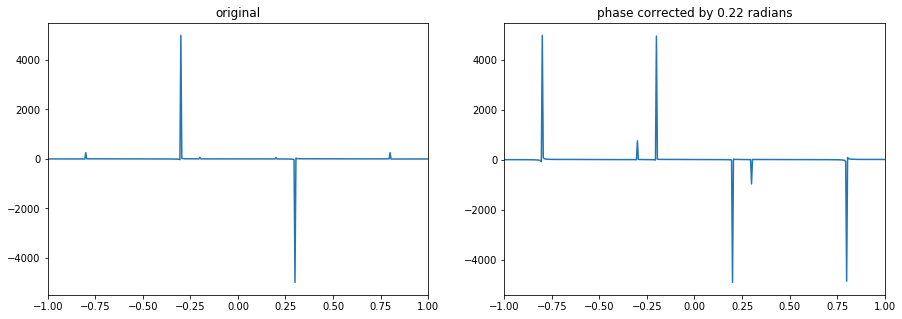

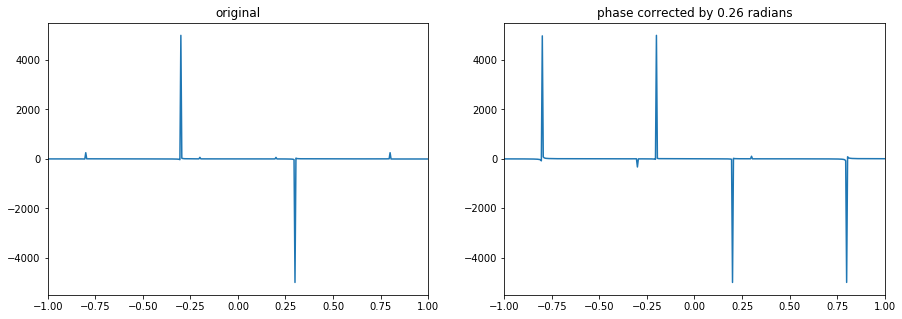

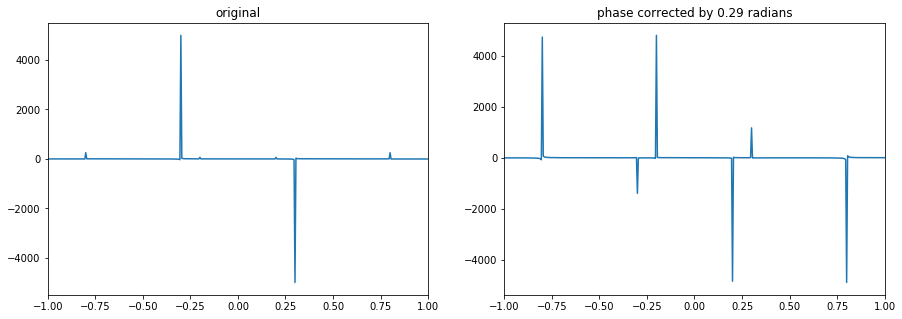

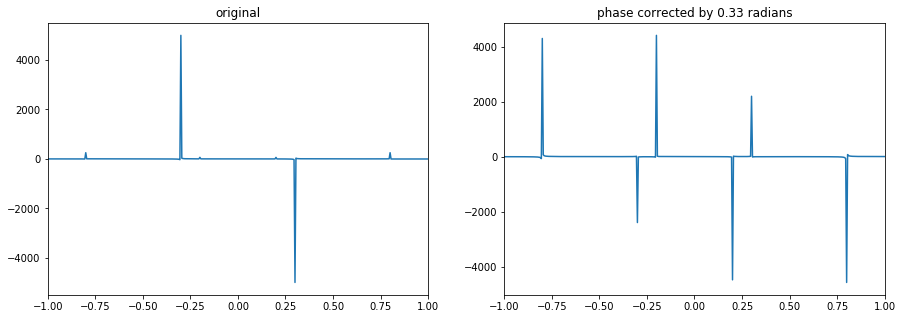

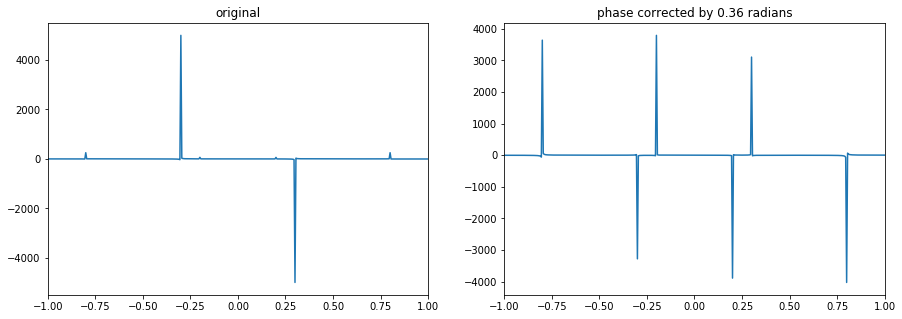

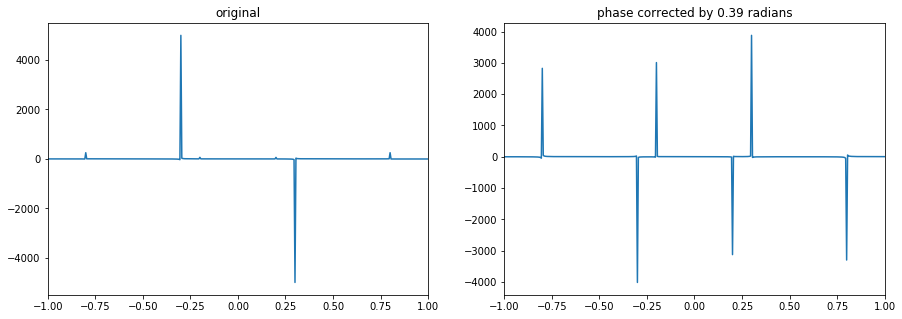

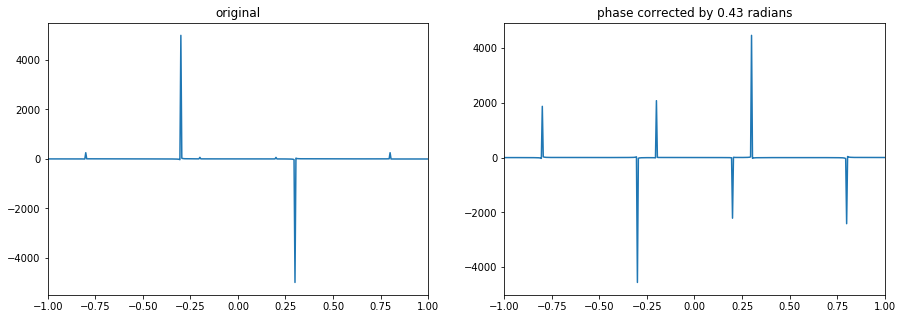

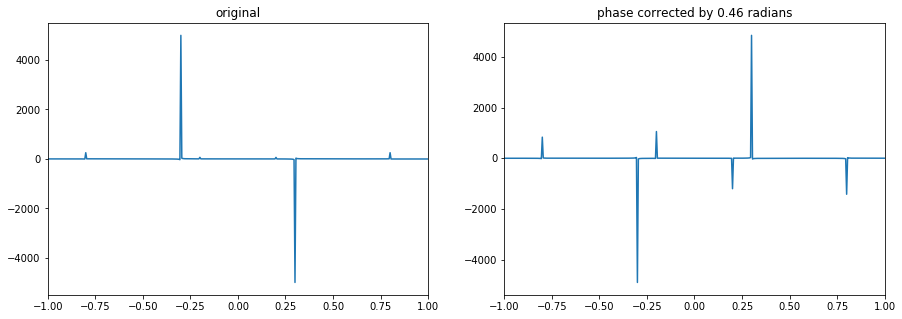

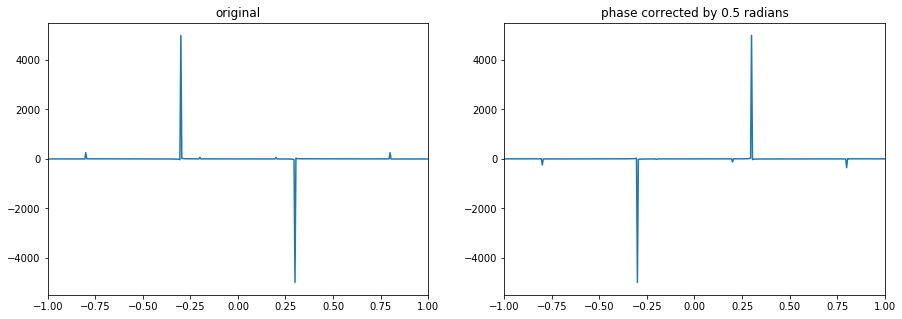

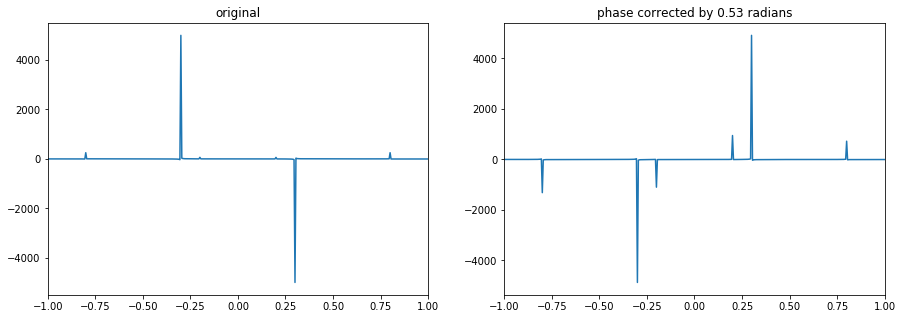

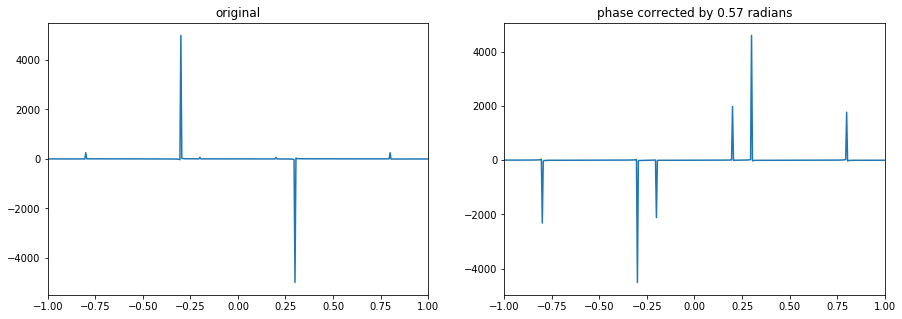

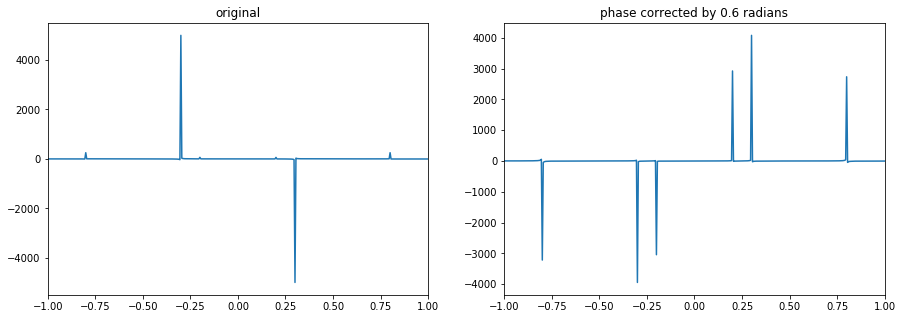

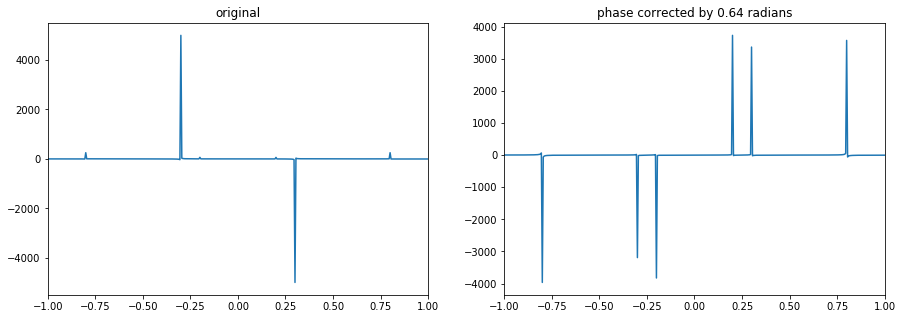

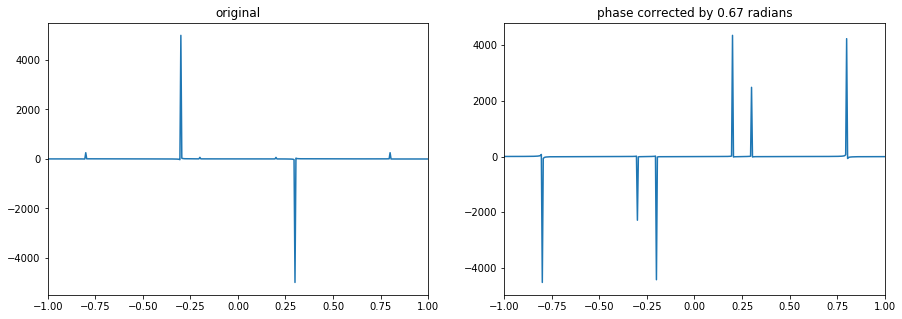

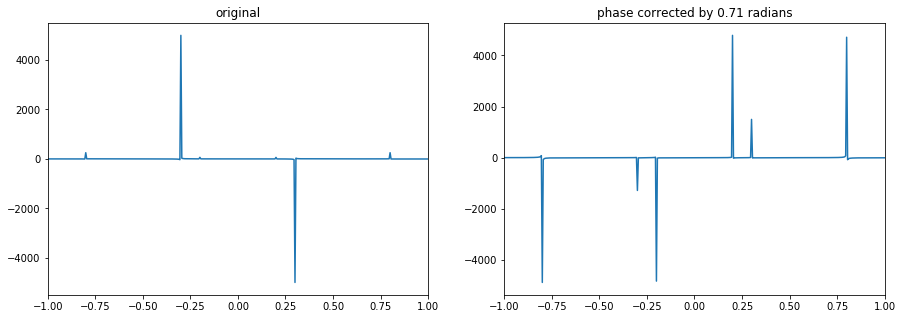

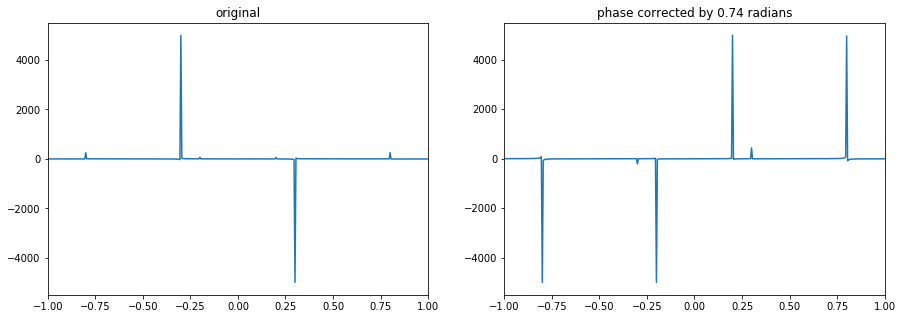

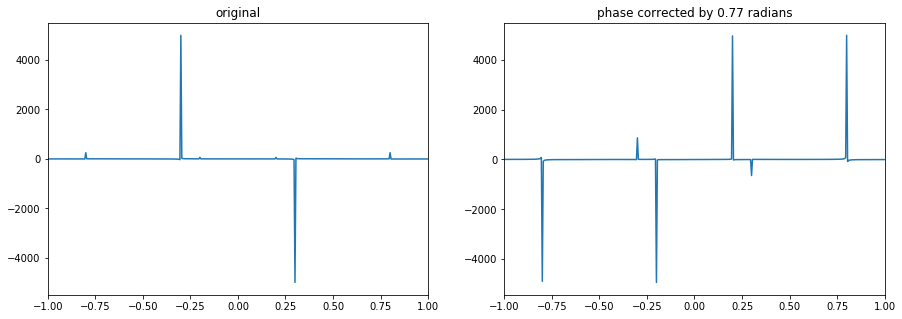

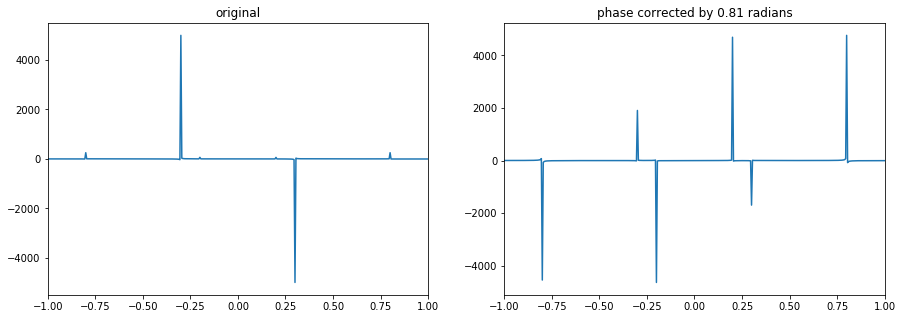

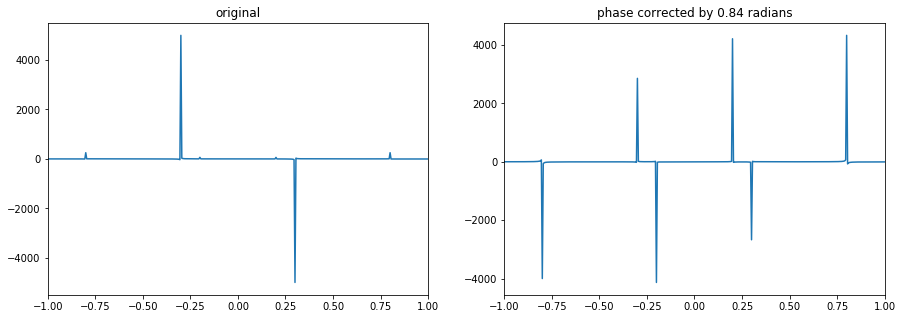

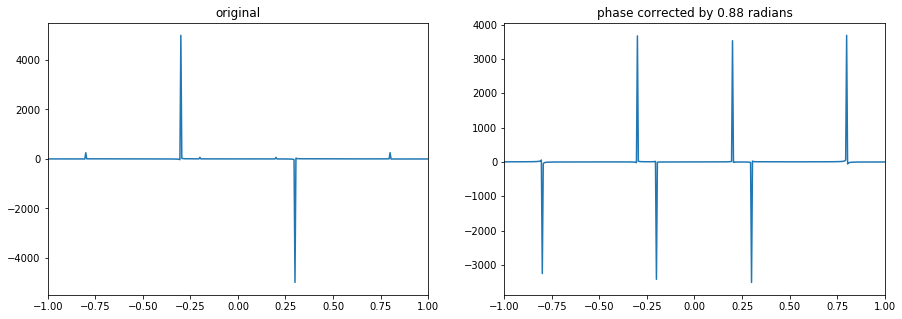

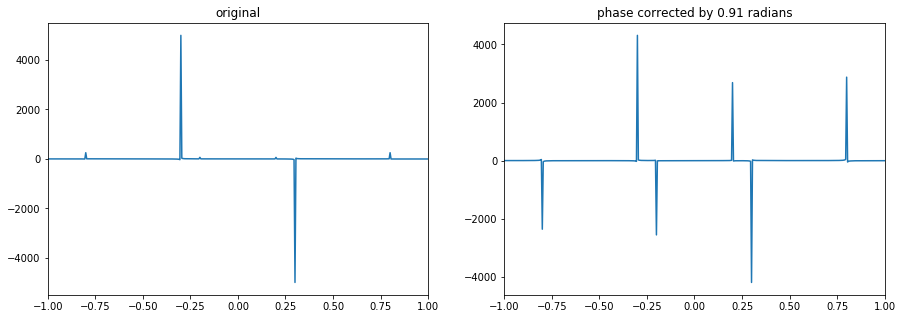

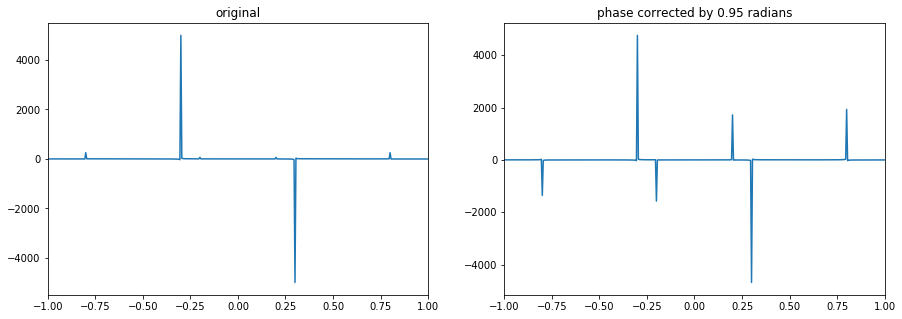

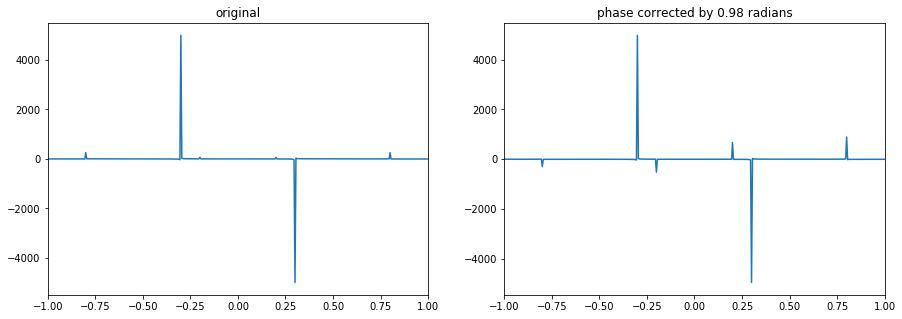

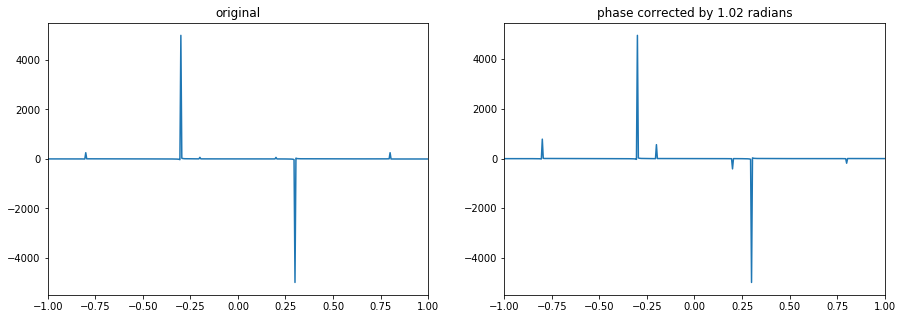

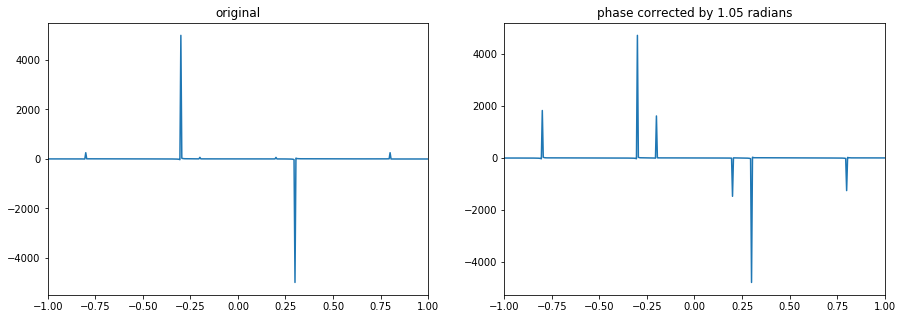

In [4]:
# simple sine wave
x = np.linspace(-100,100,10000)
y = np.sin(np.pi*2*x*0.8)+np.sin(np.pi*2*x*0.2)+1j*np.sin(np.pi*2*x*0.3)


PH1 = 0.1
# iterate through phase shift PH0
for PH0 in np.linspace(0,1,30):
    ft = fftshift(fft(y))
    freq = fftshift(fftfreq(10000, x[0]-x[1]))

    phi = PH0+np.arange(0,len(y),1)/len(y)*PH1
    ft_corr = ft.real*np.cos(np.pi*2*phi)-ft.imag*np.sin(np.pi*2*phi)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title('original')
    plt.xlim(-1,1)
    plt.plot(freq,ft)
    
    plt.subplot(1,2,2)
    plt.title(f'phase corrected by {np.round(np.mean(phi),2)} radians')
    plt.xlim(-1,1)
    plt.plot(freq,ft_corr)


    plt.show()

# Synthetic NMR data - Without Complex Input Signals
### To study the process, see the randomly generated signal (normal distribution of 10 signals multiplied by factor of 10, which has been decayed and padded).

10.353084070958872
5.320878175842248
6.684853145709175
5.396993199314569
7.9830267607757985
10.606394732306441
13.780163714012012
5.172542989311029
17.06971607487628
7.123134255619302


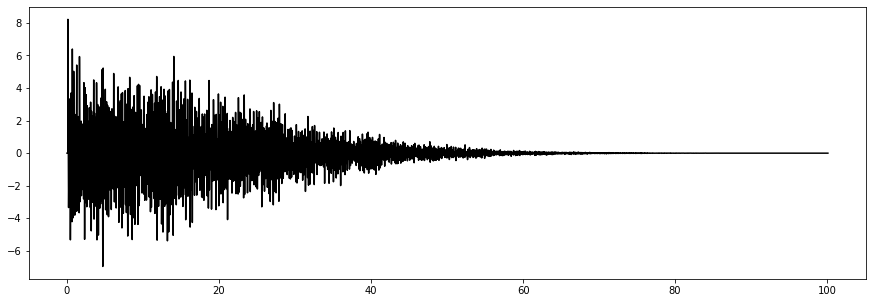

In [5]:
sample_size = 1000000
t = np.linspace(0,100,sample_size)
y = np.zeros(sample_size)
# randomly distributed frequncies
f_list = []
for n in np.random.randn(10)*10:
    print(abs(n))
    y+=np.sin(t*abs(n)*np.pi*2)
    f_list.append(abs(n))
    
# decay
y=y*np.exp(-t**2*0.001)
# pad
y = np.pad(y,(1000,10),mode='constant',constant_values=(0, 0))
# upsample
step = t[1]-t[0]
t_up = np.linspace(0,step*len(y),len(y))
plt.figure(figsize=(15,5))
plt.plot(t_up,y, c='k')

# Show that we can get all the frequencies correctly

the red dots match up with the synthetically generated data, data is also very symmetry however it could use phase correction.

(-20, 20)

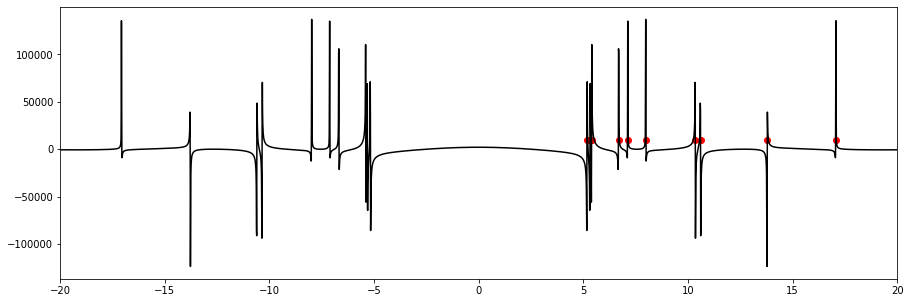

In [6]:
# Fourier transform
ft = fftshift(fft(y))
freq = fftshift(fftfreq(len(y),step))
plt.figure(figsize=(15,5))
plt.plot(freq,ft,c='k')
plt.scatter(f_list,10000*np.ones_like(f_list), c='r')
plt.xlim(-20,20)

### requires optimization of PH0 and PH1

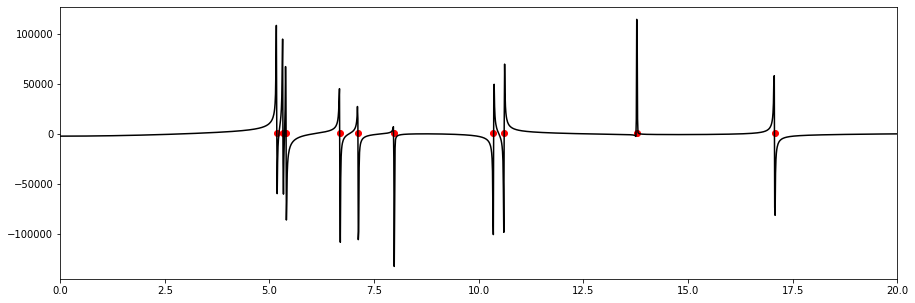

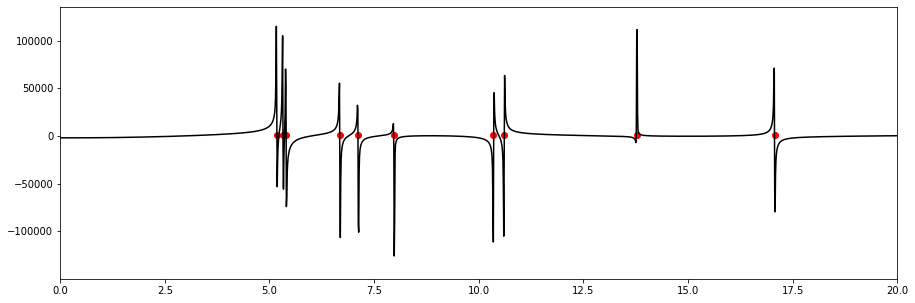

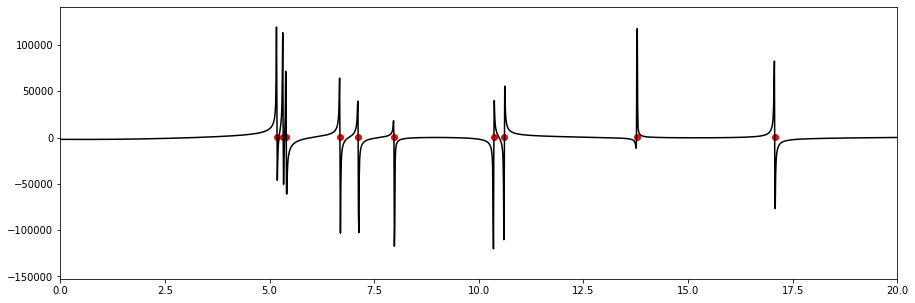

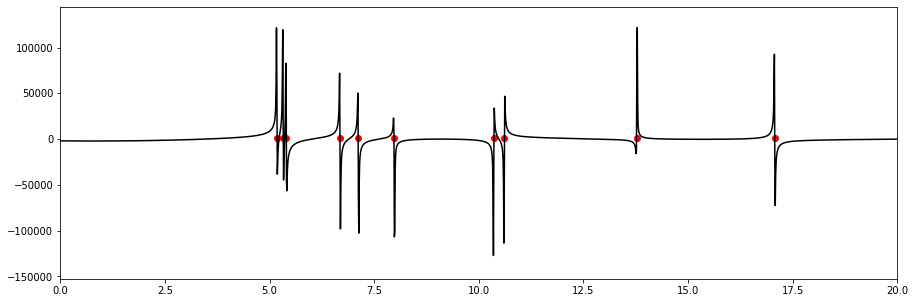

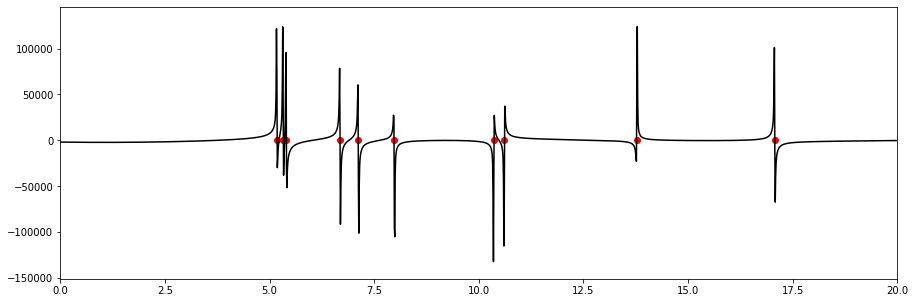

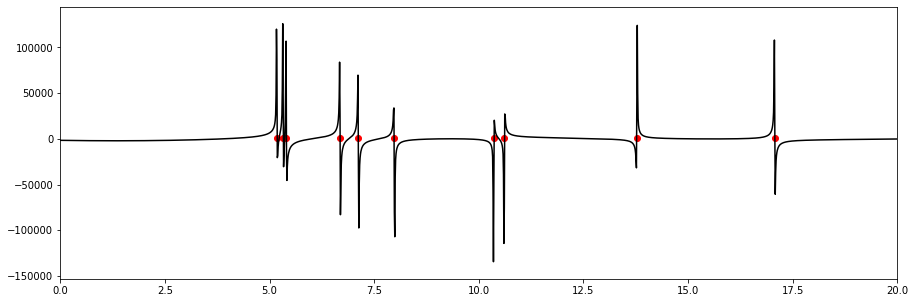

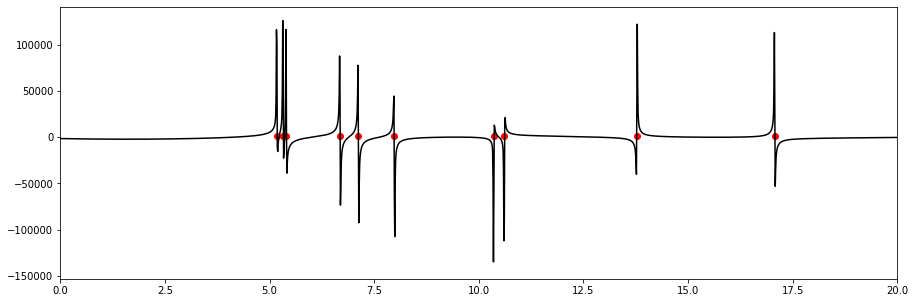

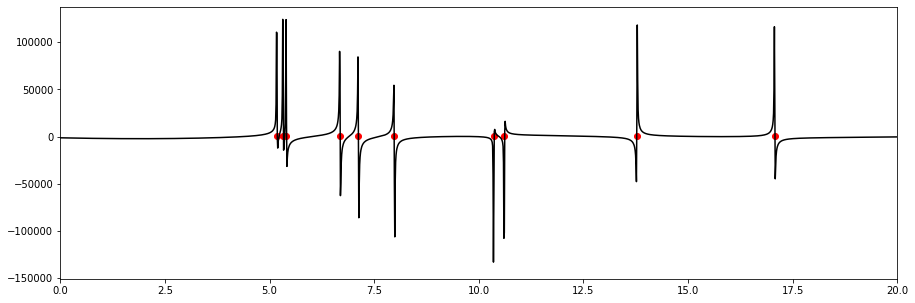

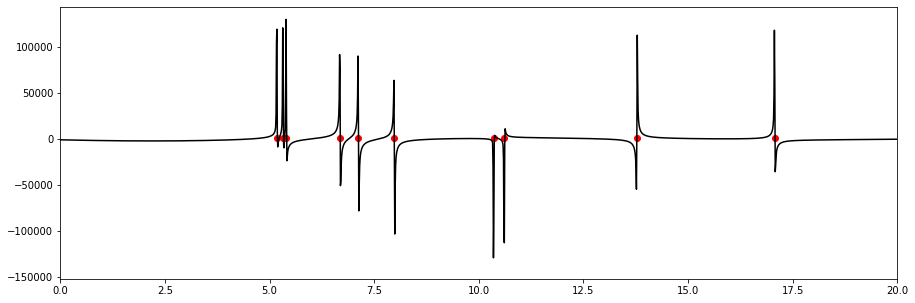

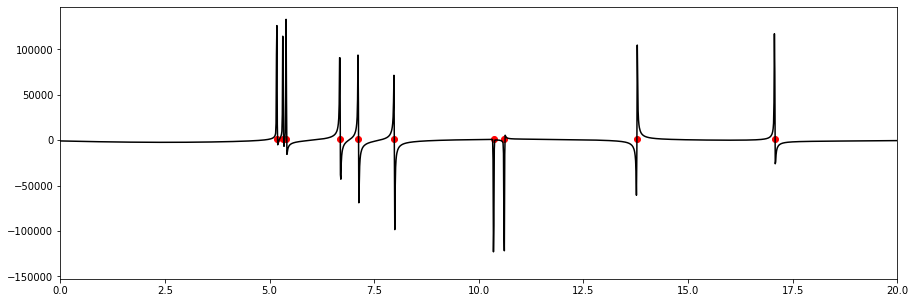

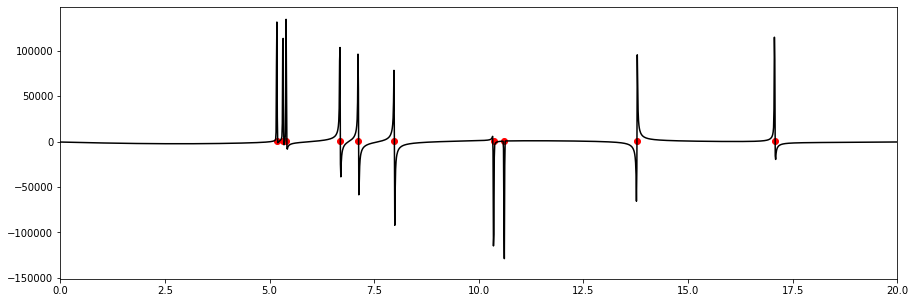

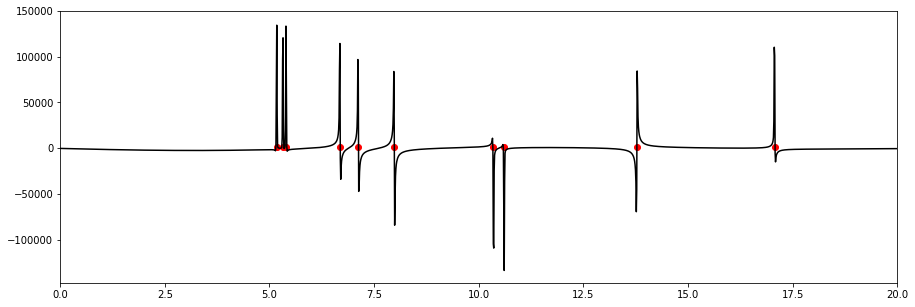

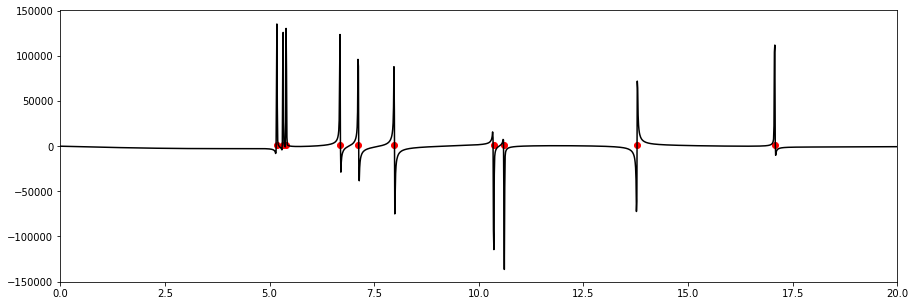

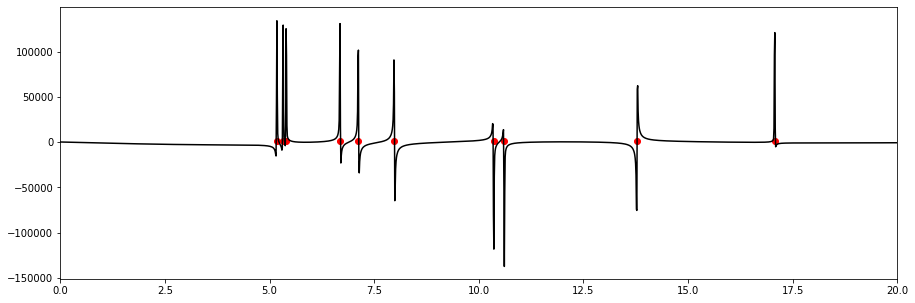

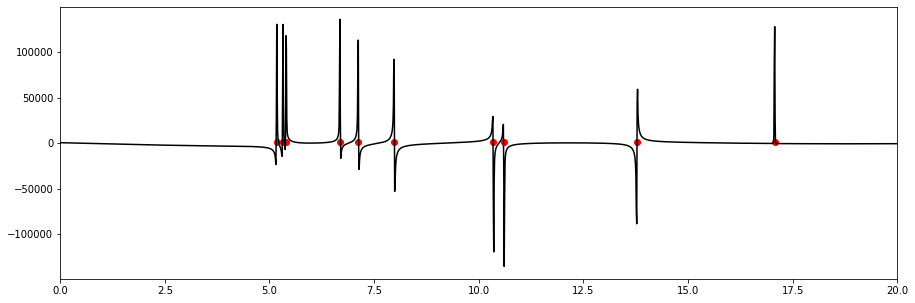

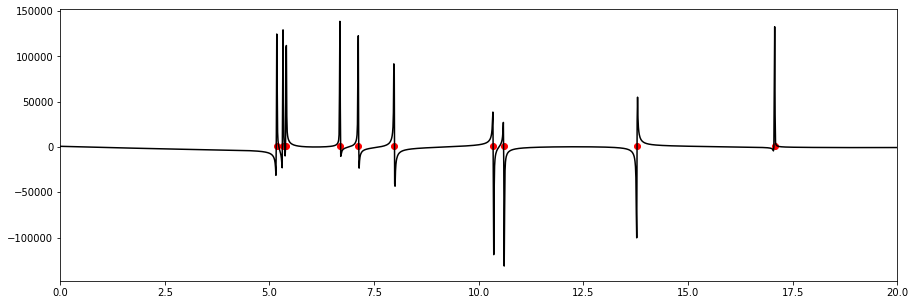

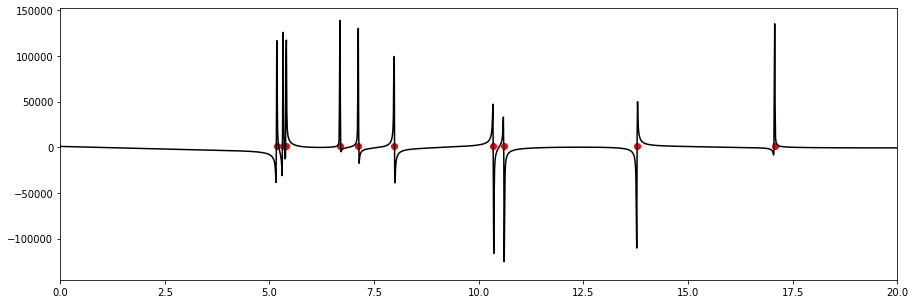

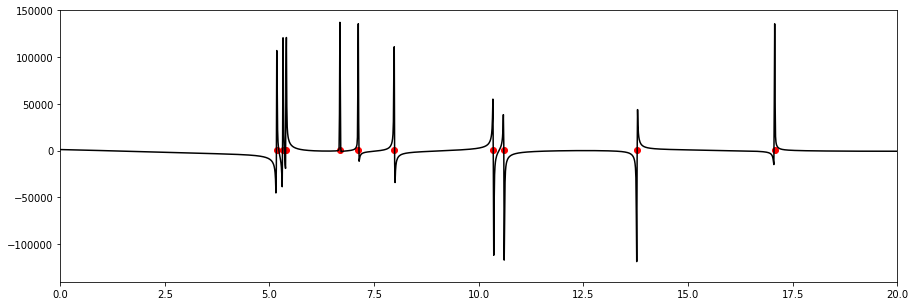

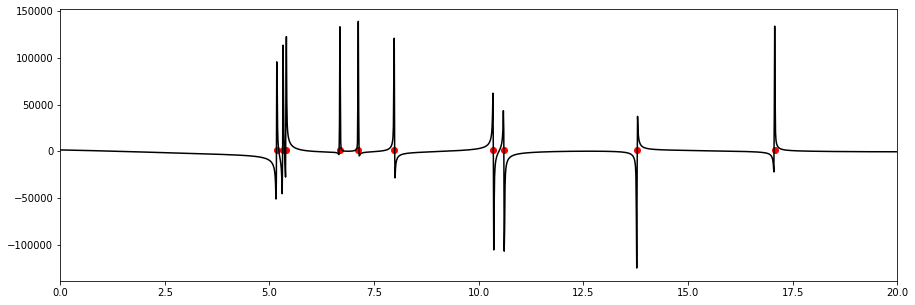

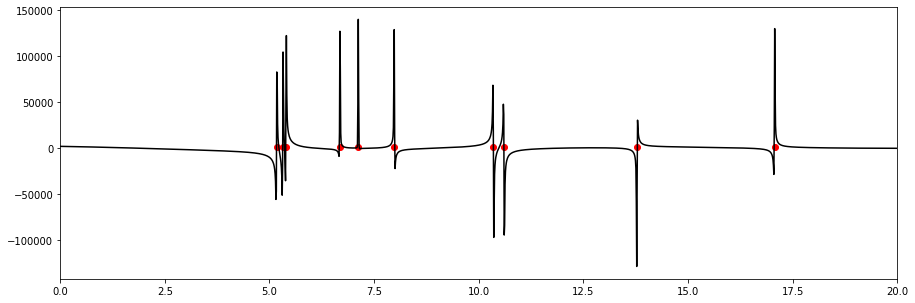

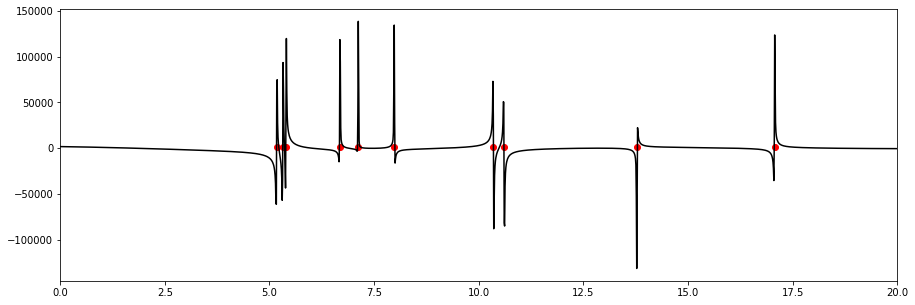

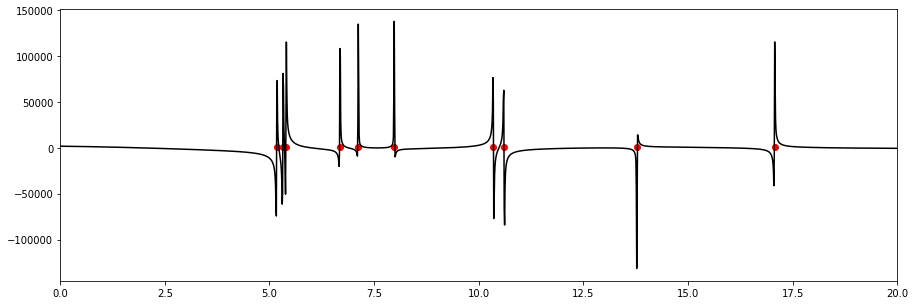

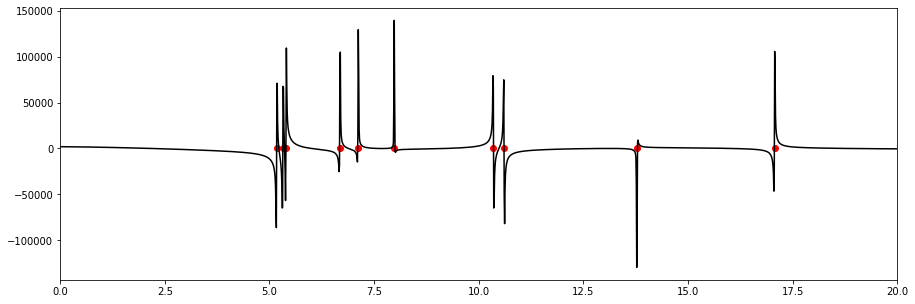

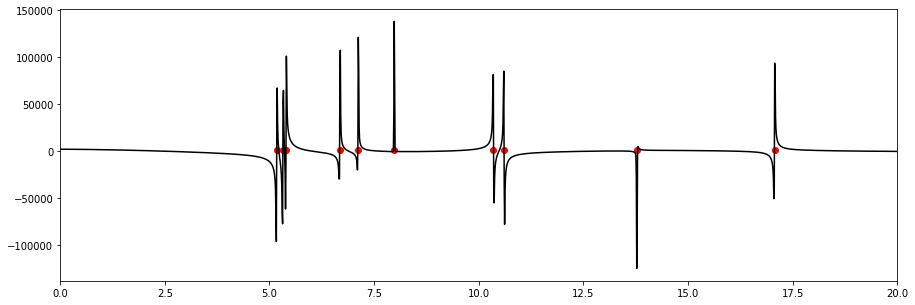

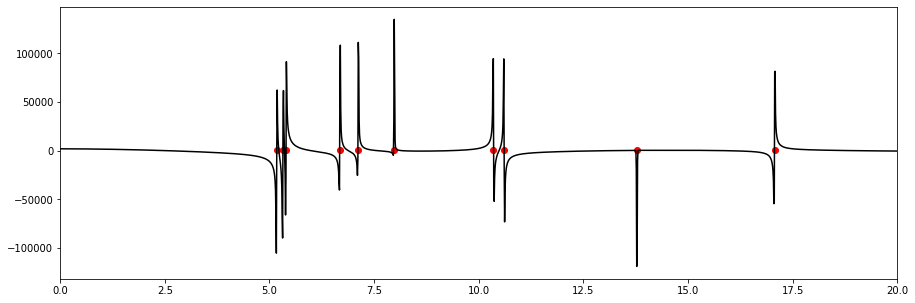

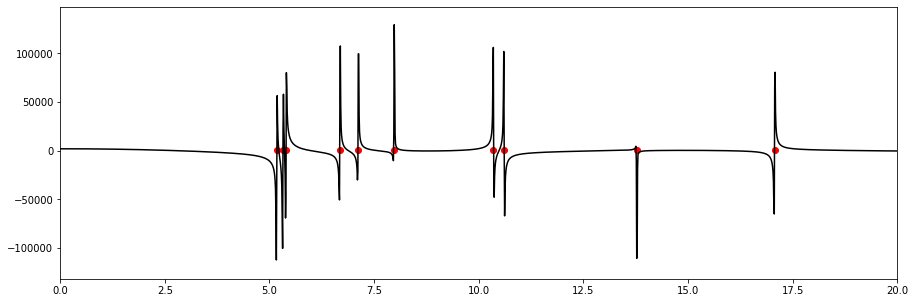

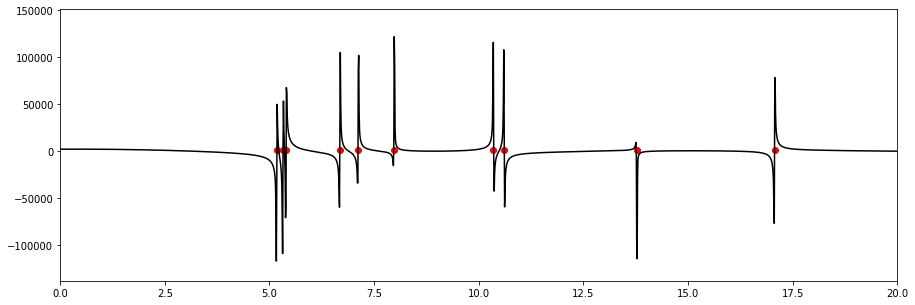

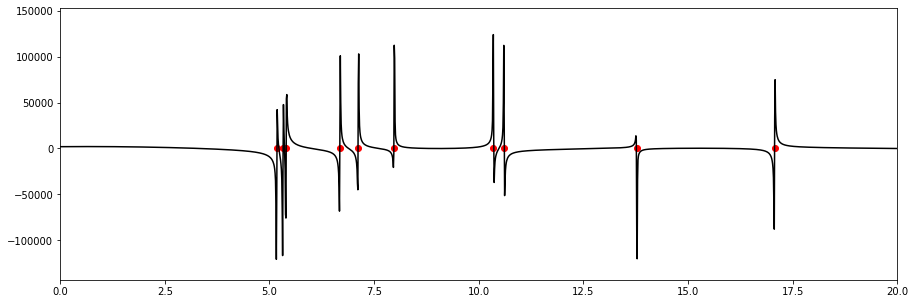

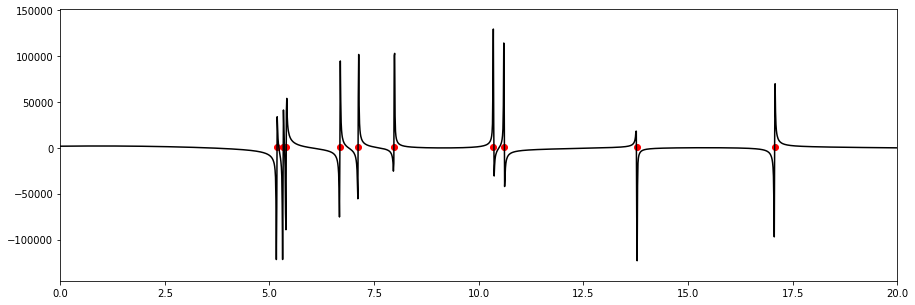

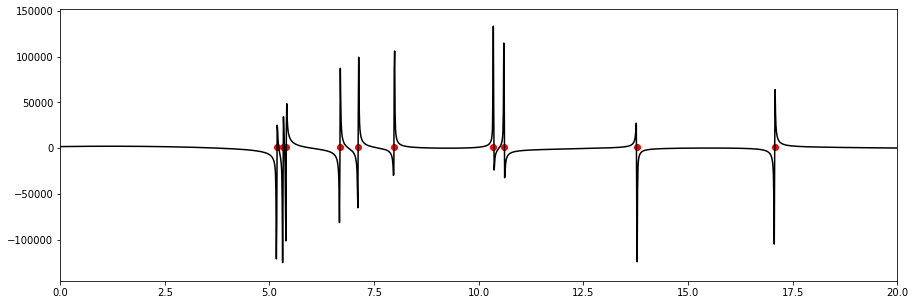

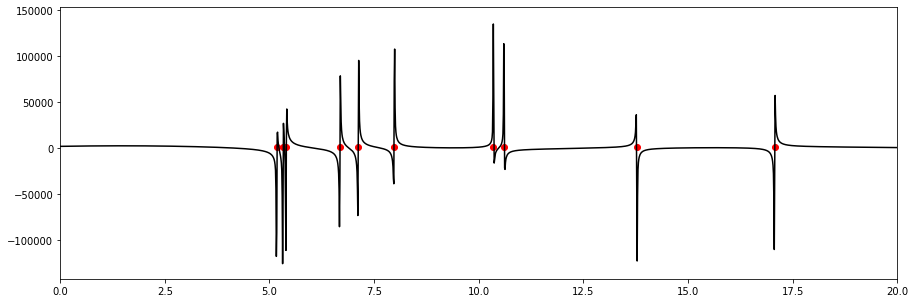

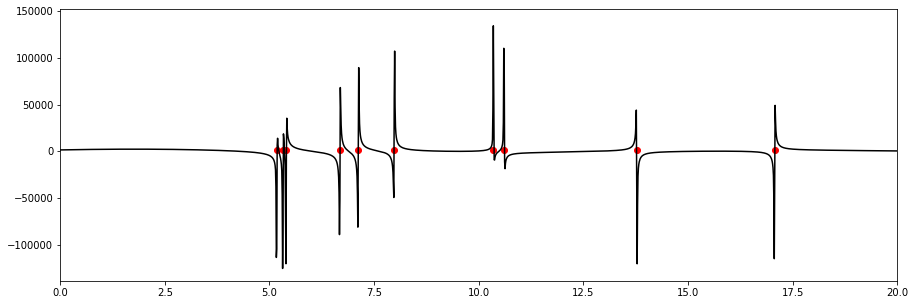

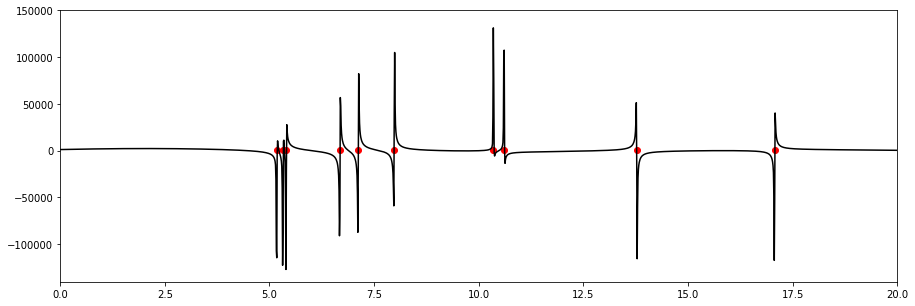

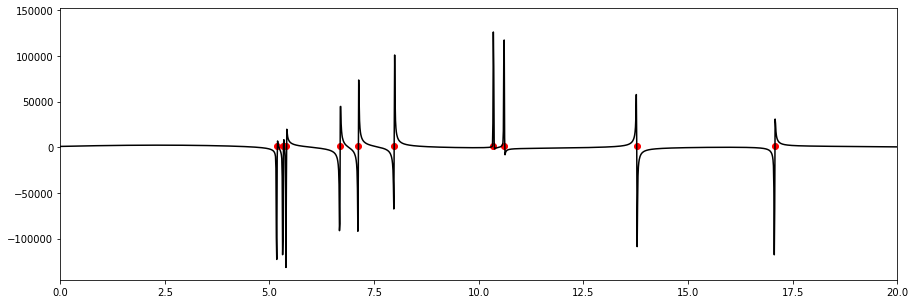

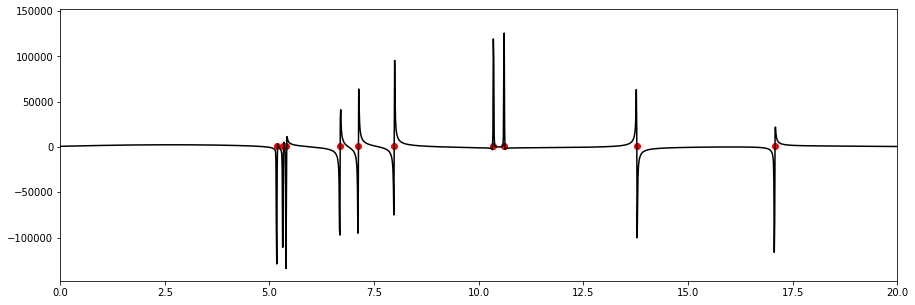

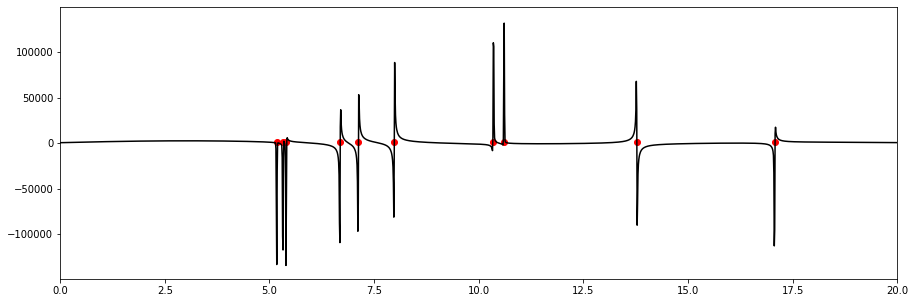

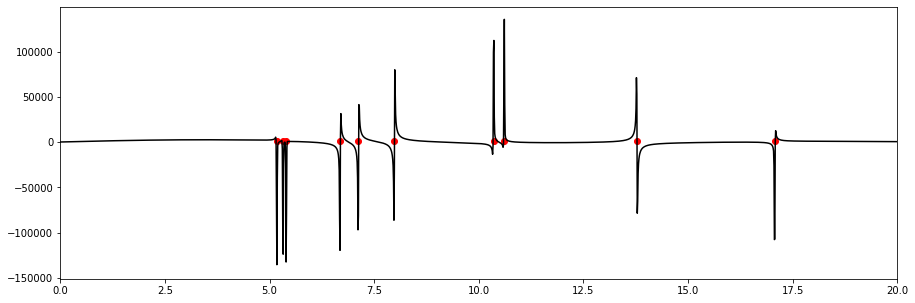

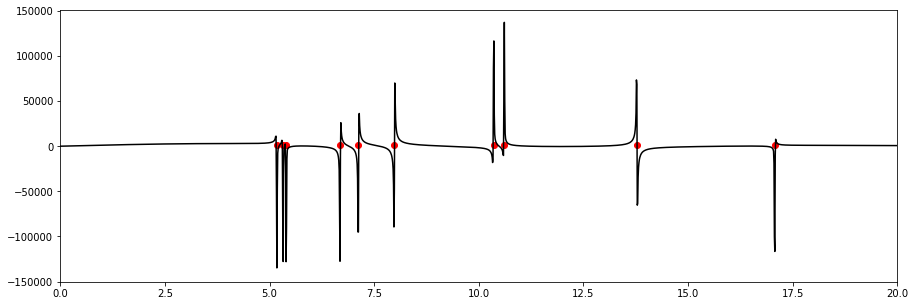

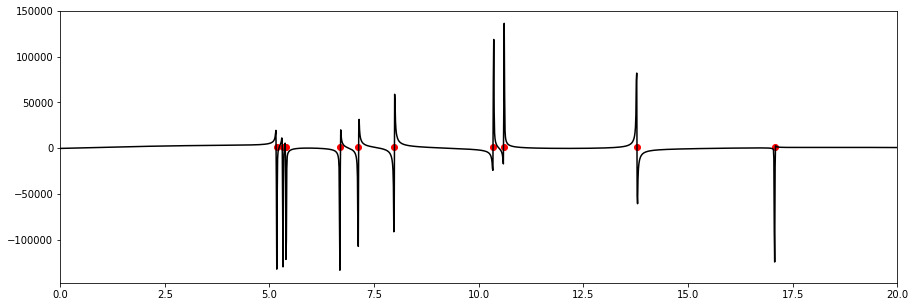

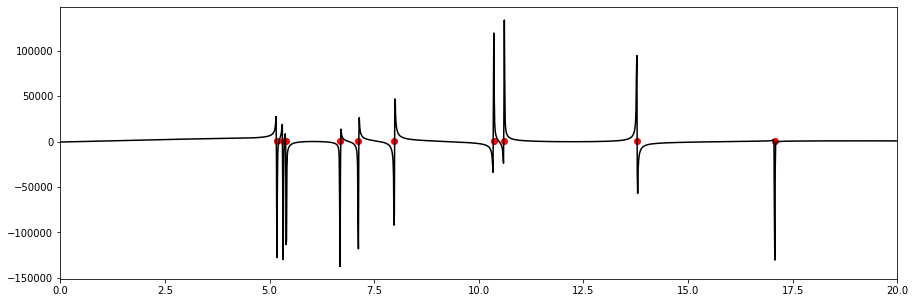

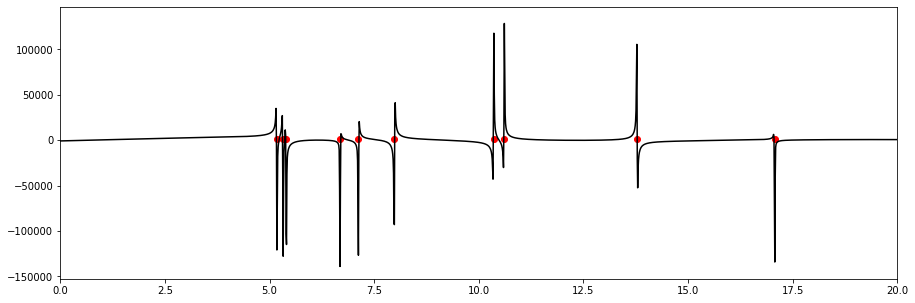

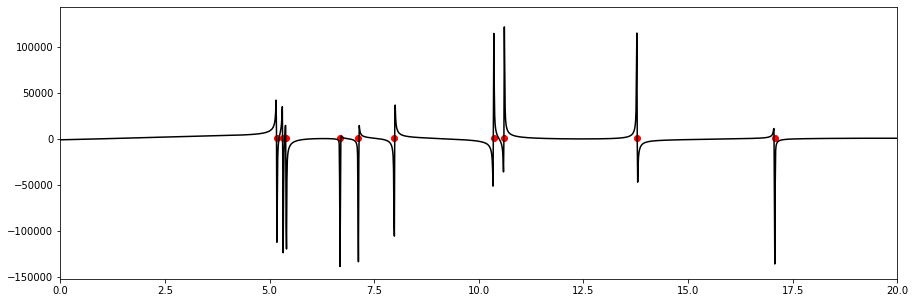

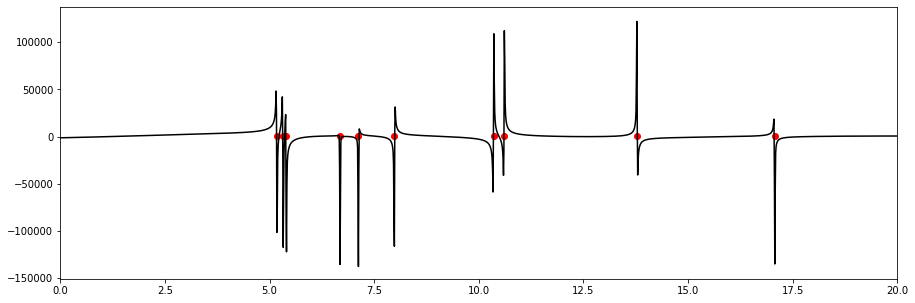

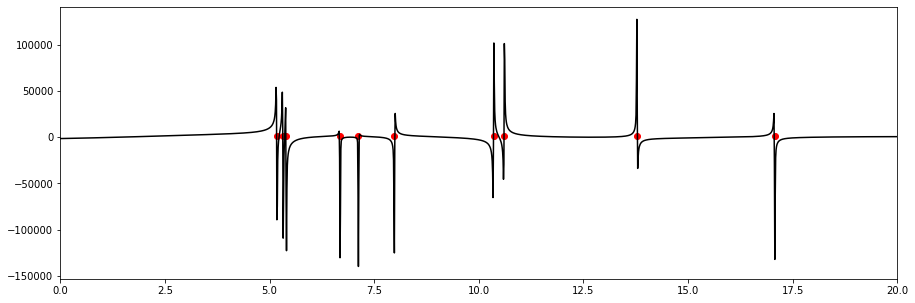

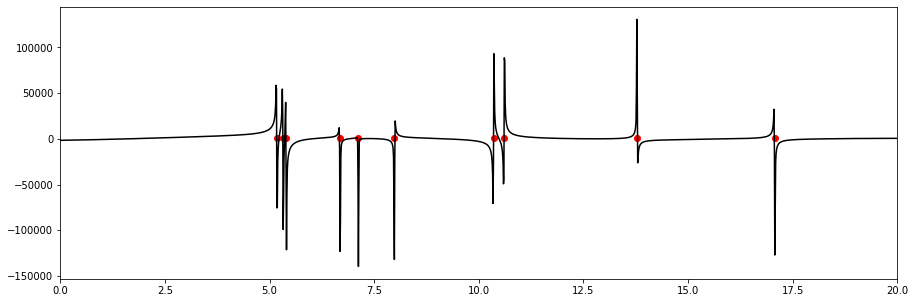

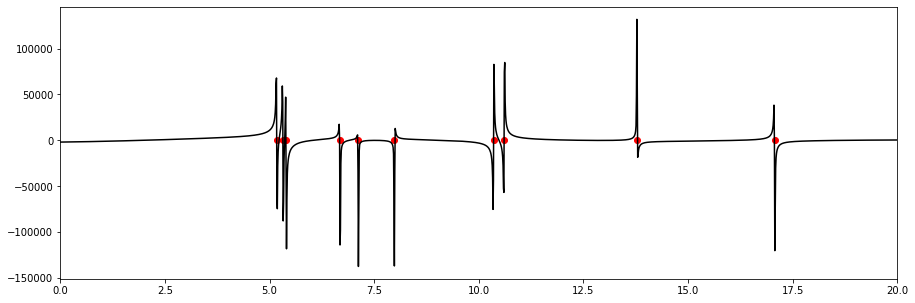

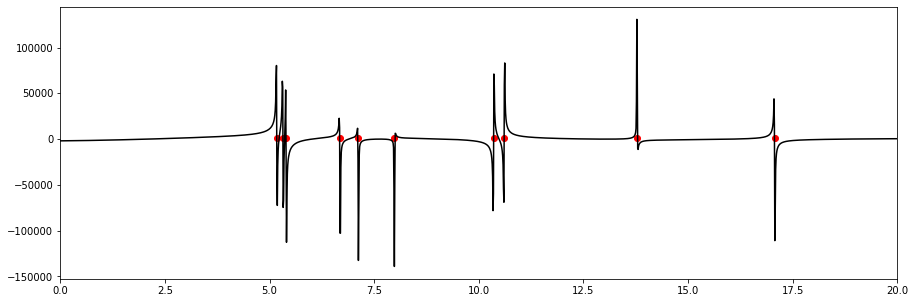

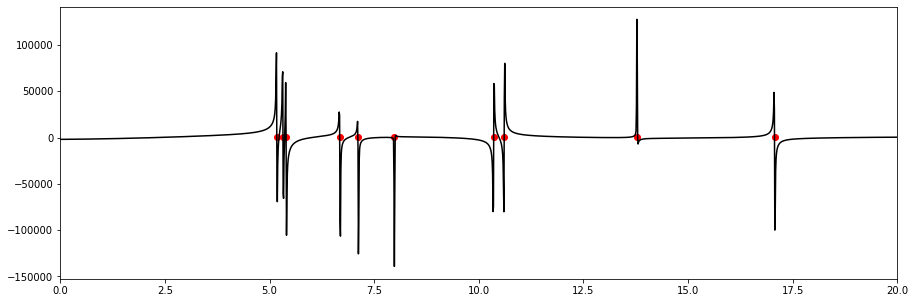

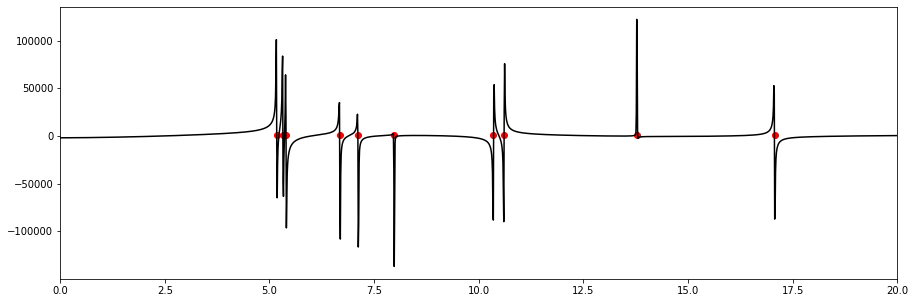

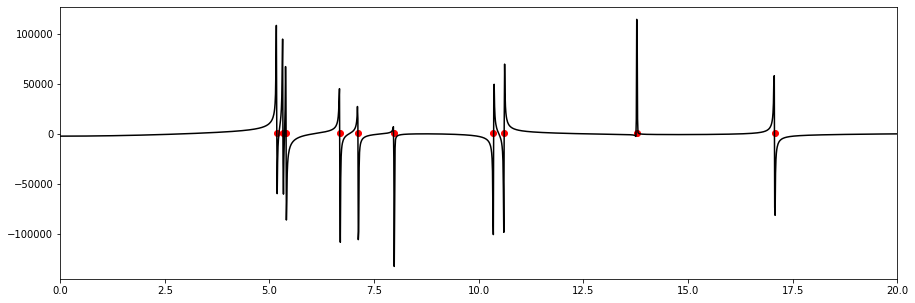

In [7]:
# phase correct
tau = 0#100
#PH0 = 10
PH1 = 100
for PH0 in np.linspace(-0.5,0.5,50):
    phi = PH0+PH1*np.arange(0,len(freq),1)/len(y)
    ft_corr = ft.real*np.cos(np.pi*2*phi)-ft.imag*np.sin(np.pi*2*phi)
    plt.figure(figsize=(15,5))
    plt.plot(freq,ft_corr,c='k')
    plt.scatter(f_list,1000*np.ones_like(f_list), c='r')
    plt.xlim(0,20)
    plt.show()


In [8]:
data_pc_pm = ng.process.proc_autophase.autops(ft, 'peak_minima', p0=0.0, p1=0.0)

Optimization terminated successfully.
         Current function value: 0.000129
         Iterations: 54
         Function evaluations: 101


(-10, 10)

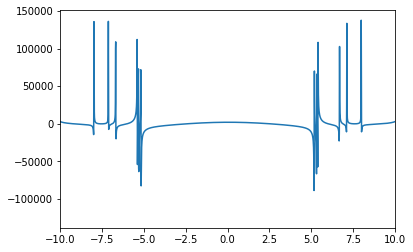

In [9]:
plt.plot(freq, data_pc_pm)
plt.xlim(-10,10)


# Lets have a look at complex input signals

27.507996895090045 8.60056341813702
6.844598907654632 24.27817680222587


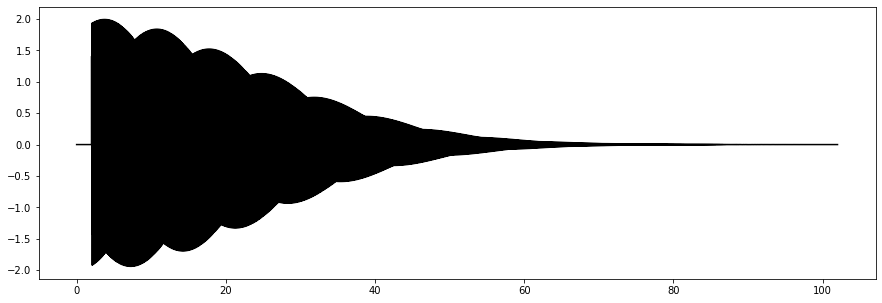

In [18]:
sample_size = 5000000
t = np.linspace(0,100,sample_size)
y = np.zeros(sample_size)+1j*np.zeros(sample_size)
# randomly distributed frequncies
f_list_r = []
f_list_i = []
for n,m in zip(np.random.randn(2)*10, np.random.randn(2)*10):
    print(abs(n),abs(m))
    y+=np.sin(t*abs(n)*np.pi*2)+1j*np.sin(t*abs(m)*np.pi*2)
    f_list_r.append(abs(n))
    f_list_i.append(abs(m))
    
# decay
y=y*np.exp(-t**2*0.001)
# pad
y = np.pad(y,(100000,10),mode='constant',constant_values=(0, 0))
# upsample
step = t[1]-t[0]
t_up = np.linspace(0,step*len(y),len(y))
plt.figure(figsize=(15,5))
plt.plot(t_up,y, c='k')

(-20, 20)

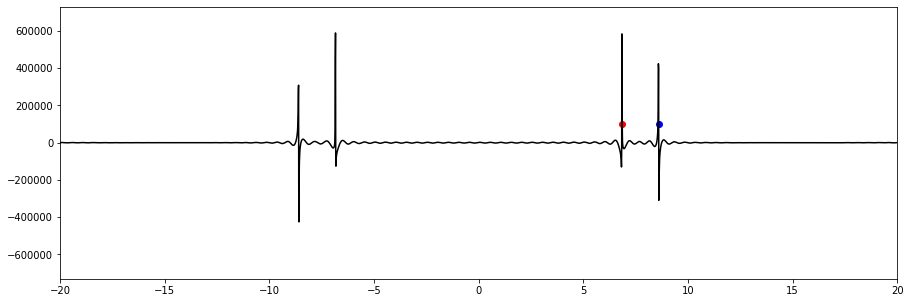

In [19]:
# Fourier transform
ft = fftshift(fft(y))
freq = fftshift(fftfreq(len(y),step))
plt.figure(figsize=(15,5))
plt.plot(freq,ft,c='k')
plt.scatter(f_list_r,100000*np.ones_like(f_list_r), c='r')
plt.scatter(f_list_i,100000*np.ones_like(f_list_r), c='b')
plt.xlim(-20,20)

# Correct the phase

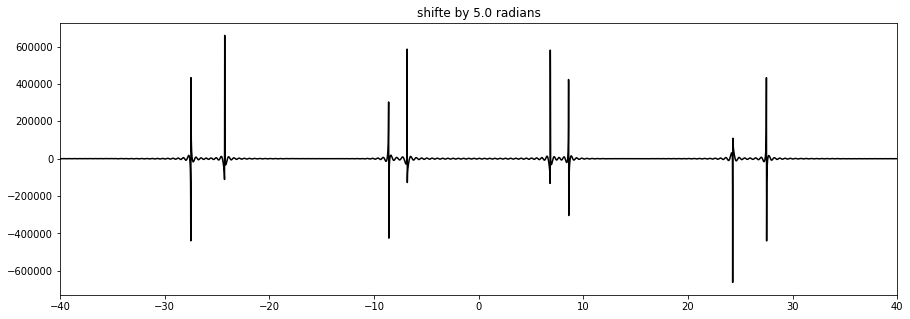

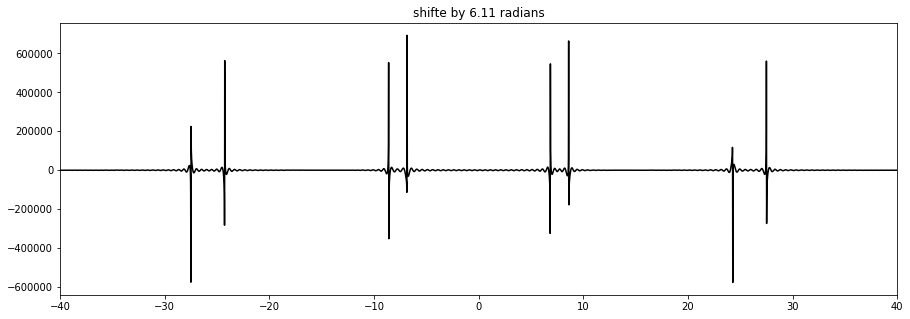

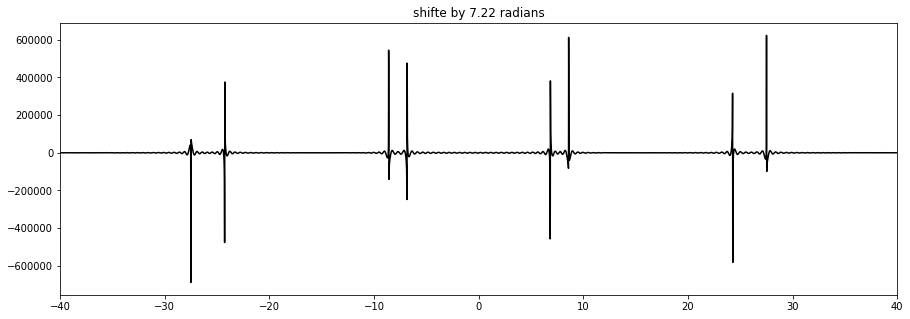

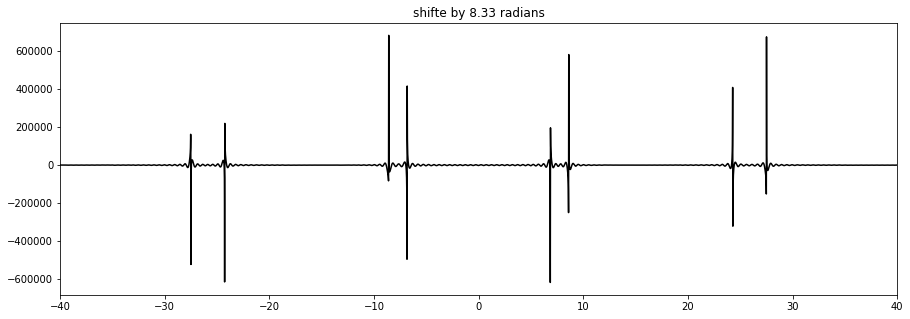

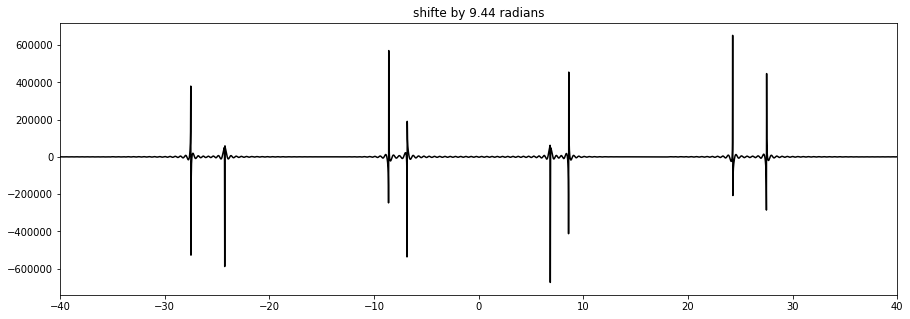

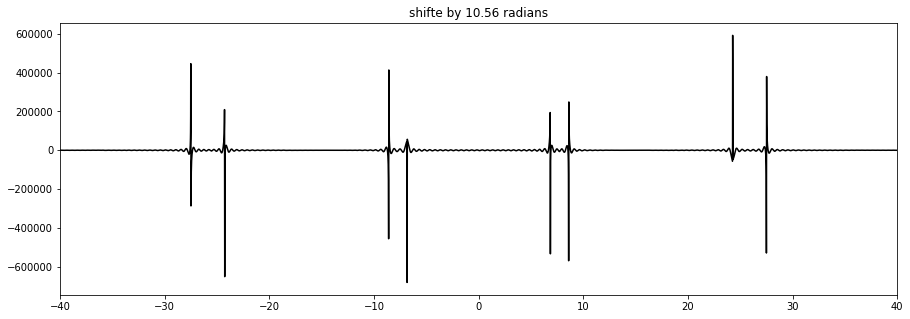

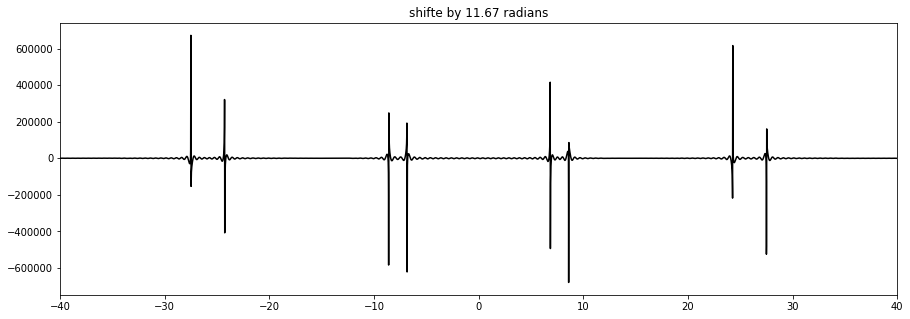

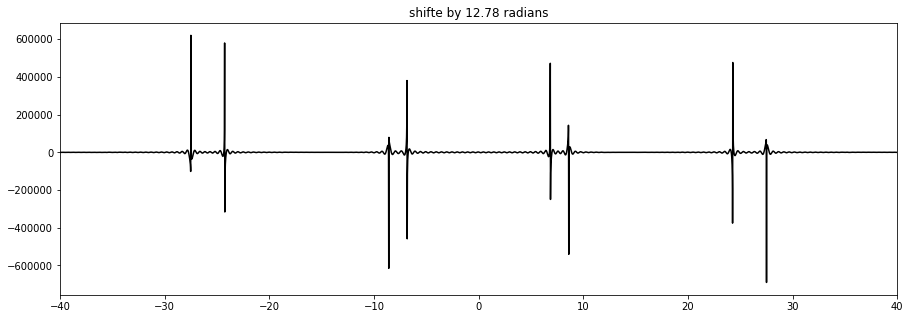

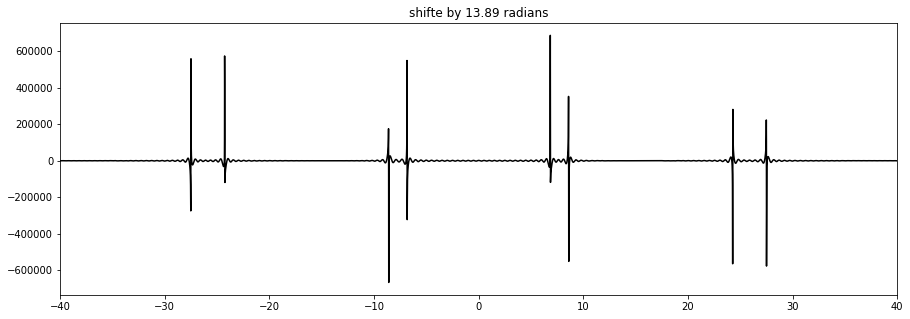

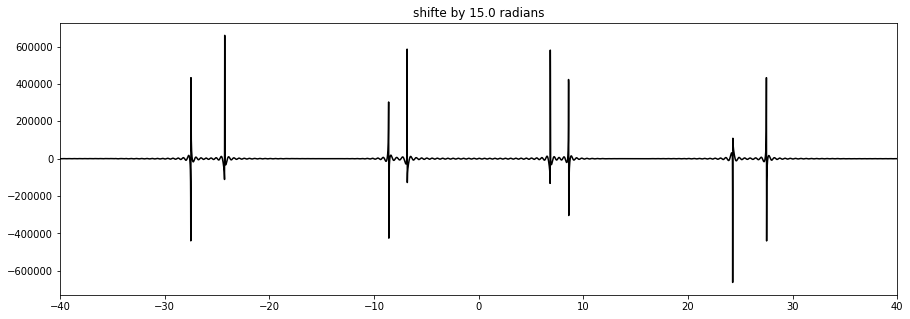

In [29]:
PH1 = 10
for PH0 in np.linspace(0,10,10):
    phi = PH0+PH1*np.arange(0,len(freq),1)/len(freq)
    tau = 100
    ft_corr = ft.real*np.cos(np.pi*2*phi)-ft.imag*np.sin(np.pi*2*phi)

    plt.figure(figsize=(15,5))
    plt.plot(freq,ft_corr,c='k')
    plt.title(f"shifte by {np.round(np.mean(phi),2)} radians")
    #plt.plot(freq,(ft_corr).imag,c='grey')
    #plt.scatter(f_list_r,1000*np.ones_like(f_list_r), c='r')
    #plt.scatter(f_list_i,1000*np.ones_like(f_list_r), c='b')
    plt.xlim(-40,40)
    plt.show()

Optimization terminated successfully.
         Current function value: 0.000069
         Iterations: 73
         Function evaluations: 134


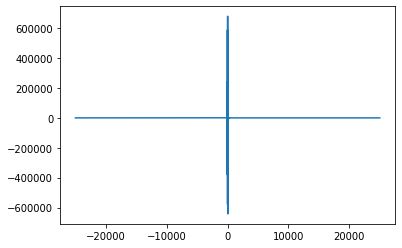

In [30]:
data_pc_pm = ng.process.proc_autophase.autops(ft, 'acme', p0=0.0, p1=0.0)

(-40, 40)

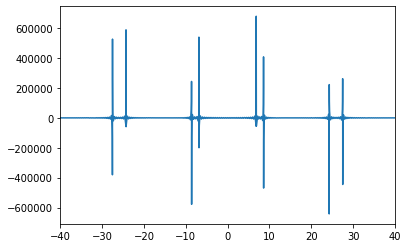

In [31]:
plt.plot(freq,data_pc_pm)
plt.xlim(-40,40)

# Analyze Real NMR Data

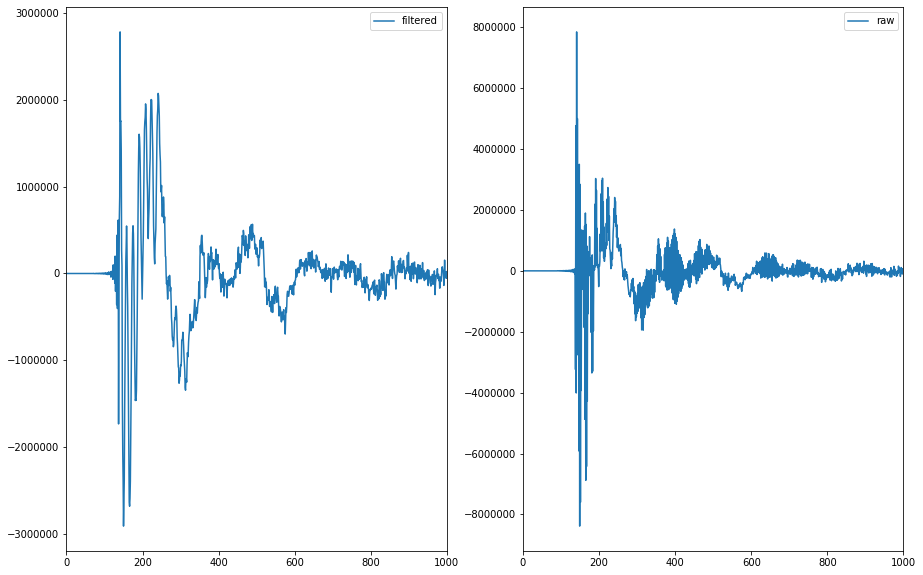

In [14]:
# put file here:
data = np.loadtxt(r'ascii-fid (17.1).txt', delimiter = ',')


# filter the signal
g = data[:,1]
fs = 1000
fc = 400  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(5, w, 'low')
output = signal.filtfilt(b, a, g)
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(output, label='filtered')
plt.legend()
plt.xlim(0,1000)

plt.subplot(1,2,2)
plt.plot(g,label='raw')
plt.legend()
plt.xlim(0,1000)
plt.show()

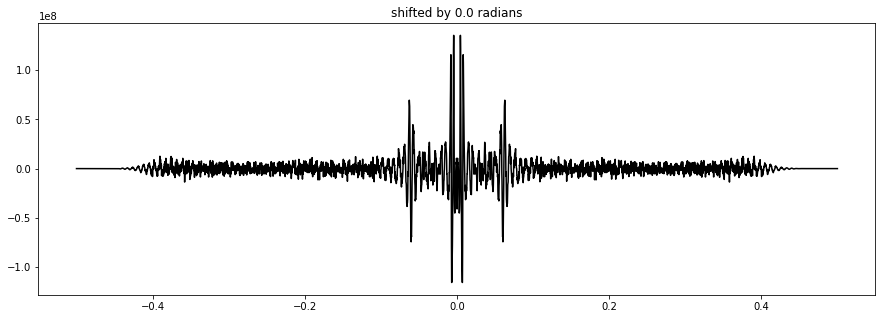

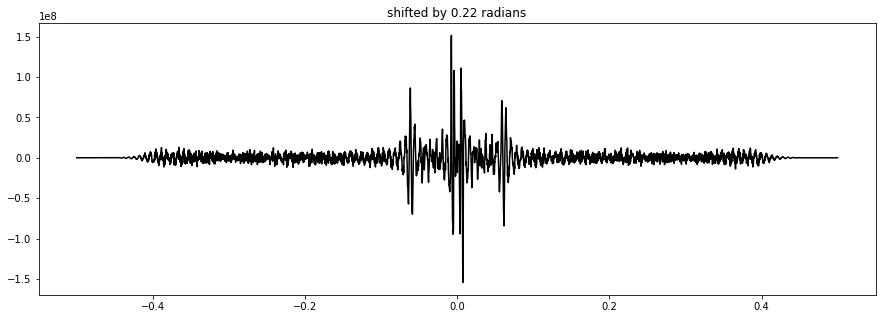

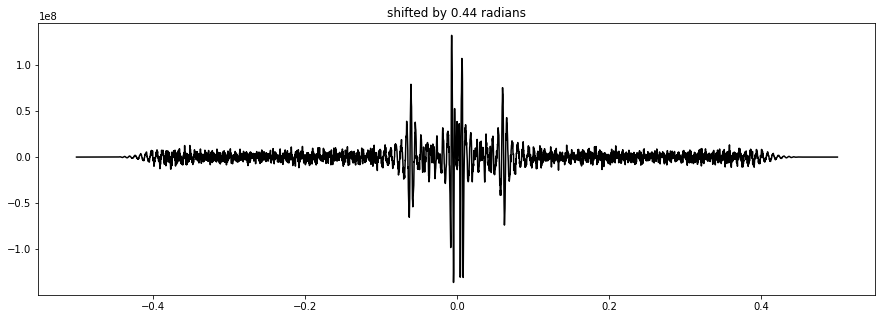

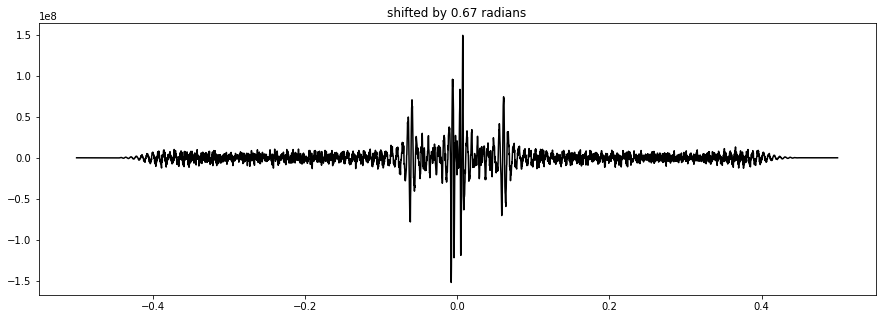

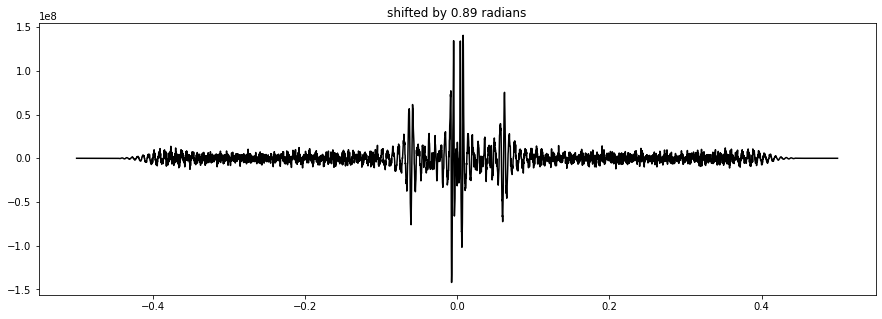

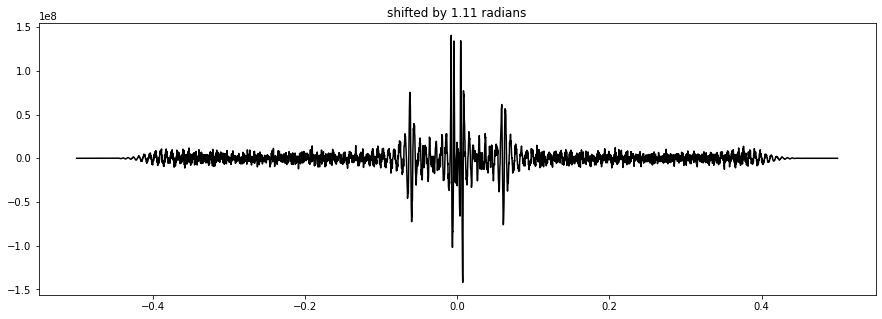

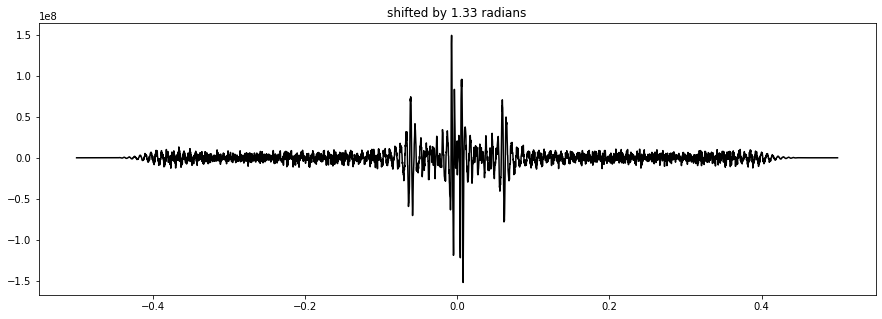

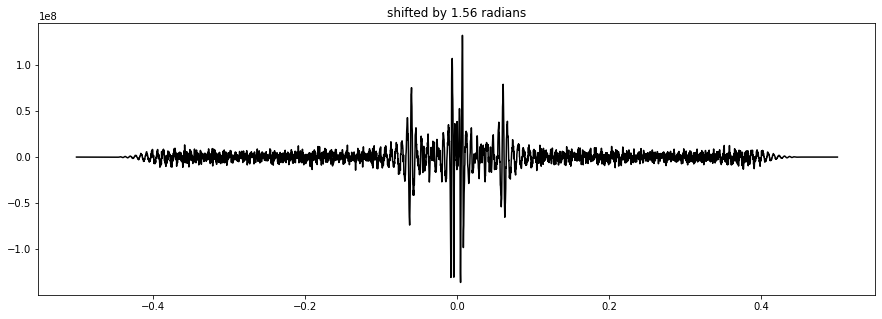

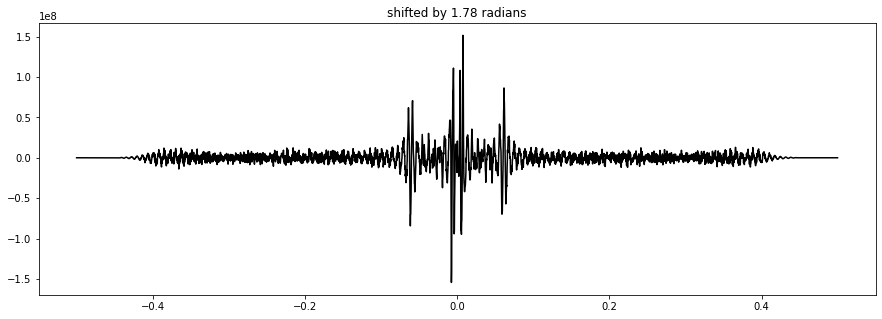

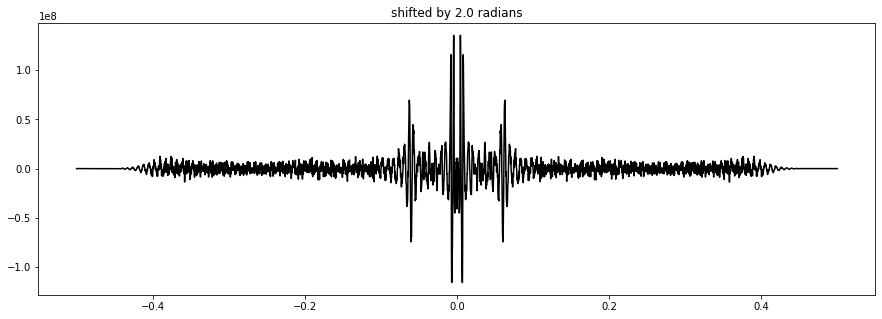

In [15]:
# Fourier transform
ft = fftshift(fft(output))
step = data[1,0]-data[0,0]
freq = fftshift(fftfreq(len(ft),step))

# phase correction
for PH0 in np.linspace(0,2,10):
    phi = PH0
    ft_corr = (ft).real*np.cos(np.pi*2*phi)-(ft).imag*np.sin(np.pi*2*phi)

    plt.figure(figsize=(15,5))
    plt.plot(freq,ft_corr,c='k')
    plt.title(f"shifted by {np.round(phi,2)} radians")
    #plt.plot(freq,(ft_corr).imag,c='grey')
    #plt.scatter(f_list_r,1000*np.ones_like(f_list_r), c='r')
    #plt.scatter(f_list_i,1000*np.ones_like(f_list_r), c='b')
    #plt.xlim(-0.1,0.1)
    plt.show()


# De Pake-ing

In [47]:
def depake(g,t):
    ft = fftshift(fft(g*np.sqrt(t)))
    step = t[1]-t[0]
    freq = fftshift(fftfreq(len(ft),step))
    
    return freq, ft*np.sqrt(abs(freq))*(1-1j)

freq, F0=depake(output, data[:,0])


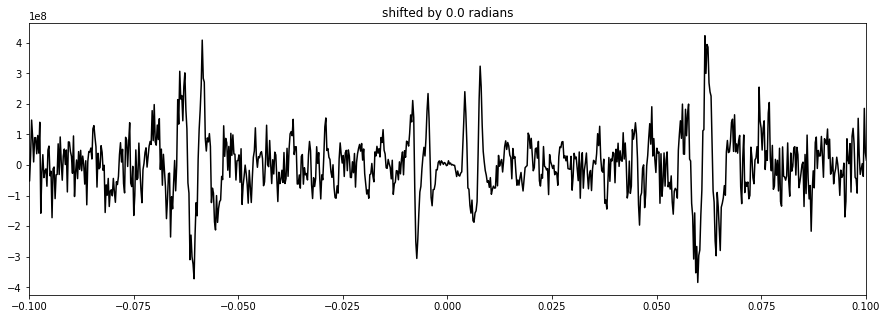

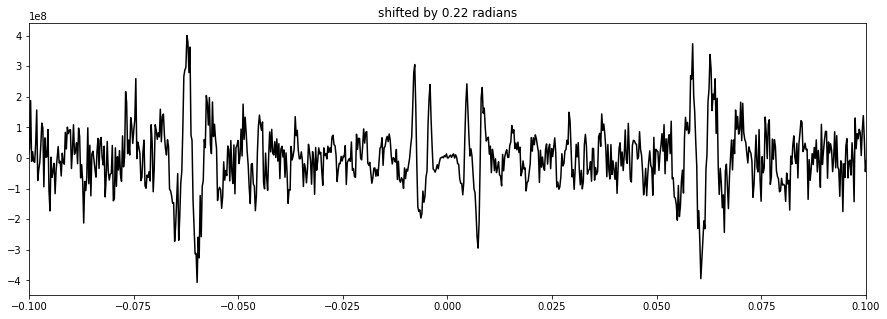

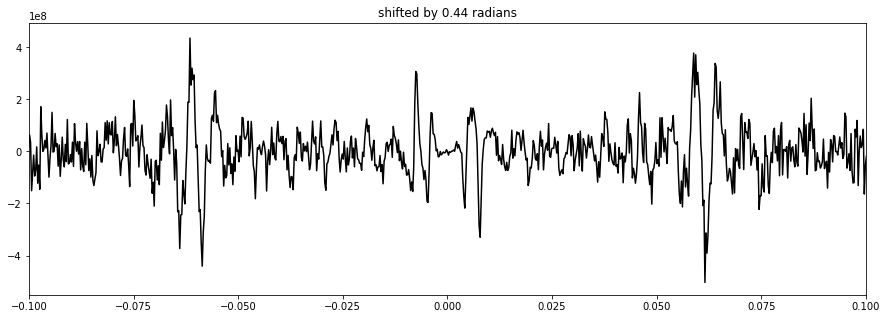

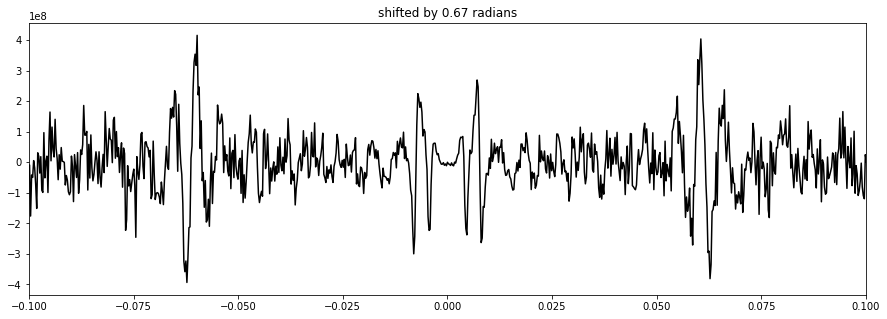

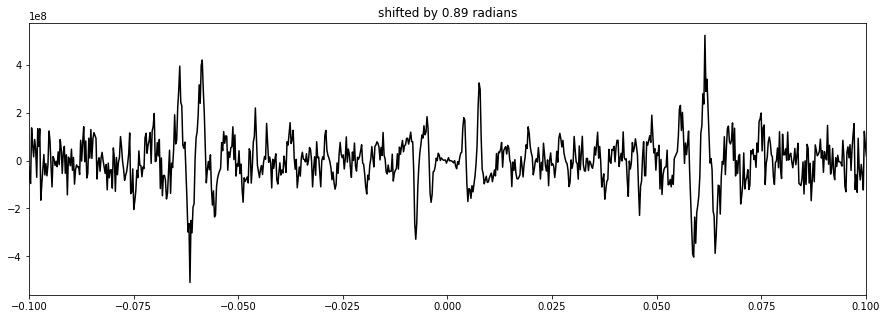

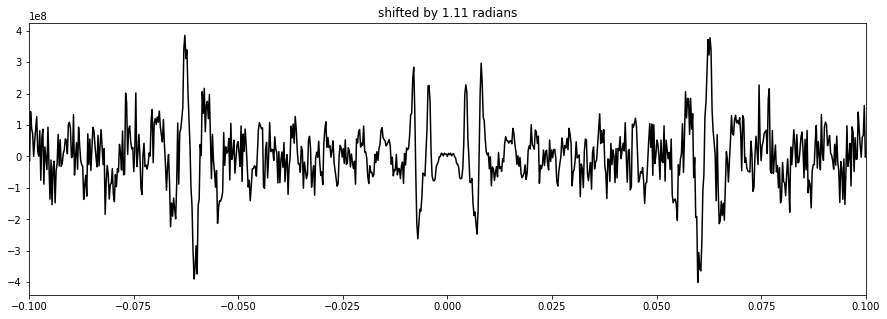

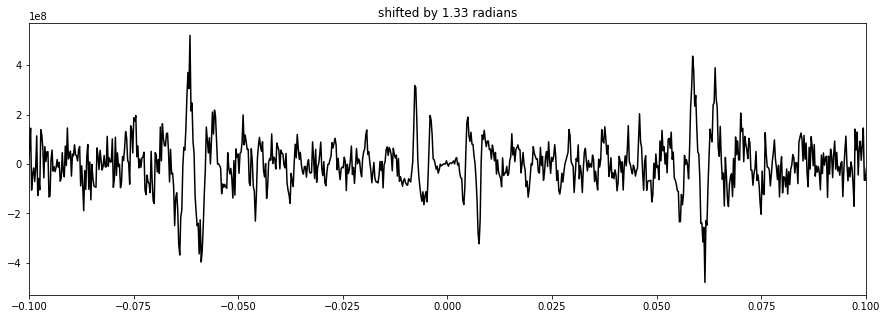

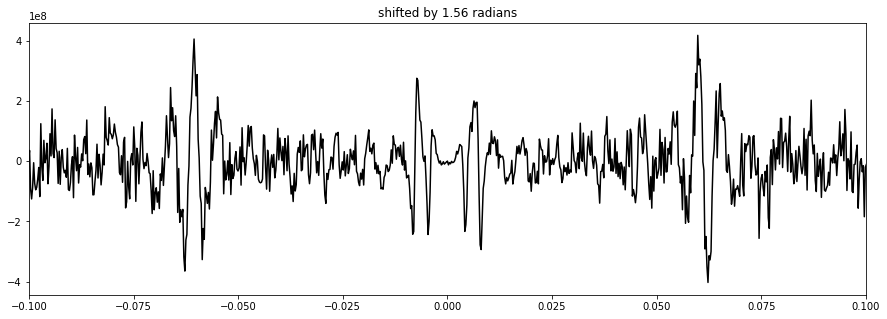

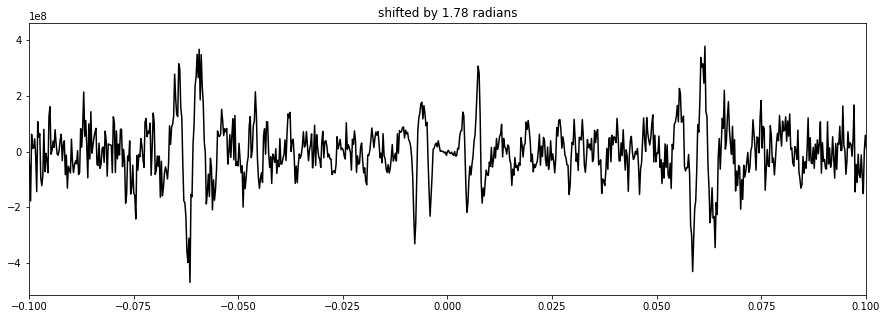

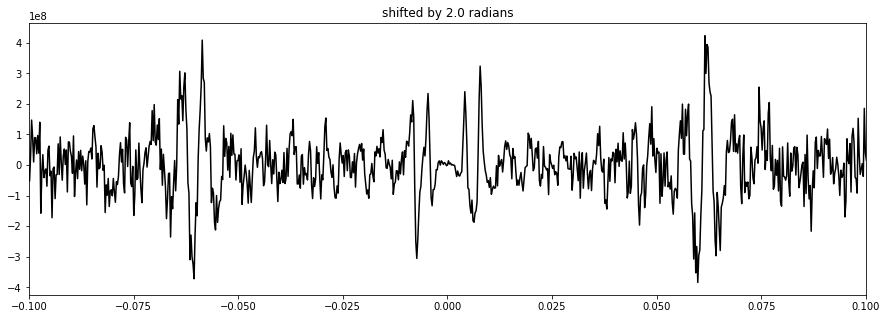

In [49]:
# phase correction
for PH0 in np.linspace(0,2,10):
    phi = PH0
    ft_corr = (F0).real*np.cos(np.pi*2*phi)-(F0).imag*np.sin(np.pi*2*phi)

    plt.figure(figsize=(15,5))
    plt.plot(freq,ft_corr,c='k')
    plt.title(f"shifted by {np.round(phi,2)} radians")
    plt.xlim(-0.1,0.1)
    plt.show()

# Try nmrglue

C:\Users\nebarlow\anaconda3\lib\site-packages\nmrglue\process\proc_base.py:616: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.fft.fftshift(np.fft.fft(data, axis=-1).astype(data.dtype), -1)


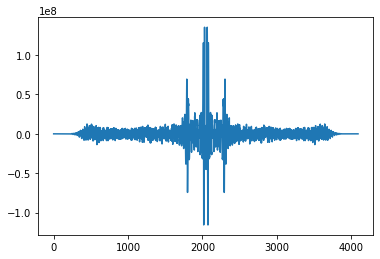

In [16]:
ft = ng.process.proc_base.fft(output)
plt.plot(ft)

C:\Users\nebarlow\anaconda3\lib\site-packages\nmrglue\process\proc_base.py:937: ComplexWarning: Casting complex values to real discards the imaginary part
  ).astype(data.dtype)


Optimization terminated successfully.
         Current function value: 7.529466
         Iterations: 169
         Function evaluations: 324


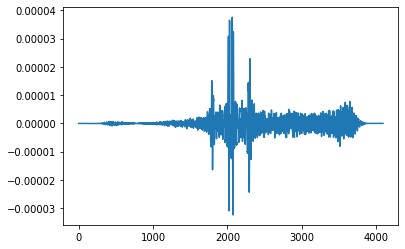

In [17]:
ft_autops = ng.process.proc_autophase.autops(ft, "acme", p0=0, p1=0)
plt.plot(ft_autops)

In [1]:
# save as HTML
!jupyter nbconvert NMR_toy_model.ipynb --to html



[NbConvertApp] Converting notebook NMR_toy_model.ipynb to html
[NbConvertApp] Writing 5814375 bytes to NMR_toy_model.html
